In [ ]:
import os
import json
import re
import logging
import warnings
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats

import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.model_selection import ParameterGrid, GridSearchCV, random_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, PoissonRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from tqdm import tqdm
from dotenv import load_dotenv
from sqlalchemy import create_engine
from IPython.core.display import display, HTML, clear_output
import holidays

warnings.filterwarnings("ignore", category=ConvergenceWarning)
tqdm.pandas()
warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:90% !important; }</style>"))
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)



load_dotenv()
db_config = {
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'database': os.getenv('DB_NAME')
}

db_url = f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(db_url, connect_args={'connect_timeout': 600})

/var/folders/x2/3p459hxs50n3j_bqtz00yclm0000gn/T/ipykernel_4295/632046093.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
/var/folders/x2/3p459hxs50n3j_bqtz00yclm0000gn/T/ipykernel_4295/632046093.py:26: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


In [2]:
finbert_query = """
    SELECT * FROM daily_finbert_sentiment
"""
feature_query = """
    SELECT * FROM feature_data
"""

In [3]:

with engine.connect() as connection:
    sentiment = pd.read_sql(finbert_query, con=connection)
    features = pd.read_sql(feature_query, con=connection)
    
sentiment.business_date = pd.to_datetime(sentiment.business_date)
features.business_date = pd.to_datetime(features.business_date)
sentiment.drop('close',axis=1,inplace=True)
sentiment

ticker asset_name business_date  avg_finbert_sentiment  sentiment_std  \
0      BZ=F      BRENT    2023-11-15               0.188406       0.526980   
1      BZ=F      BRENT    2023-11-16               0.118699       0.504596   
2      BZ=F      BRENT    2023-11-17               0.053232       0.506171   
3      BZ=F      BRENT    2023-11-18               0.053232       0.506171   
4      BZ=F      BRENT    2023-11-19               0.053232       0.506171   
...     ...        ...           ...                    ...            ...   
1247    SPY    S&P 500    2024-11-25              -0.003968       0.396471   
1248    SPY    S&P 500    2024-11-26              -0.006860       0.375588   
1249    SPY    S&P 500    2024-11-27               0.000608       0.366756   
1250    SPY    S&P 500    2024-11-29              -0.019036       0.303956   
1251    SPY    S&P 500    2024-12-02              -0.043413       0.273083   

      weighted_avg_finbert_sentiment  avg_finbert_sentiment_lag1  \
0                           0.147026                    0.151329   
1                           0.070196                    0.188406   
2                           0.036326                    0.118699   
3                           0.036326                    0.053232   
4                           0.036326                    0.053232   
...                              ...                         ...   
1247                        0.072110                    0.047695   
1248                        0.002603                   -0.003968   
1249                       -0.001400                   -0.006860   
1250                       -0.033180                    0.000608   
1251                       -0.046563                   -0.019036   

      weighted_avg_finbert_sentiment_lag1  avg_finbert_sentiment_diff1  \
0                                0.113070                     0.037077   
1                                0.147026                    -0.069707   
2                                0.070196                    -0.065467   
3                                0.036326                    -0.065467   
4                                0.036326                    -0.065467   
...                                   ...                          ...   
1247                             0.259192                    -0.051663   
1248                             0.072110                    -0.002891   
1249                             0.002603                     0.007468   
1250                            -0.001400                    -0.019644   
1251                            -0.033180                    -0.024377   

      weighted_avg_finbert_sentiment_diff1  ...  \
0                                 0.033956  ...   
1                                -0.076829  ...   
2                                -0.033871  ...   
3                                -0.033871  ...   
4                                -0.033871  ...   
...                                    ...  ...   
1247                             -0.187081  ...   
1248                             -0.069507  ...   
1249                             -0.004003  ...   
1250                             -0.031781  ...   
1251                             -0.013383  ...   

      weighted_finbert_sentiment_acceleration  avg_finbert_sentiment_ma_7  \
0                                   -0.070370                    0.114990   
1                                   -0.110786                    0.114022   
2                                    0.042959                    0.106818   
3                                    0.042959                    0.106818   
4                                    0.042959                    0.106818   
...                                       ...                         ...   
1247                                -0.204652                    0.038699   
1248                                 0.117574                    0.030201   
1249                                 0.065504           

In [4]:
tickers = ['CL=F', 'BZ=F', 'SPY', 'QQQ']

# min&max dates 
start_date = pd.to_datetime(sentiment.business_date.min())
end_date = pd.to_datetime(sentiment.business_date.max()) #datetime.today() + timedelta(days=2)


all_dates = pd.date_range(start=start_date, end=end_date)
all_combinations = pd.MultiIndex.from_product([tickers, all_dates], names=['ticker', 'business_date']).to_frame(index=False)
all_combinations = all_combinations.merge(sentiment,'left',['business_date','ticker']).merge(features,'left',['business_date','ticker','asset_name'])
# all_combinations = all_combinations.merge(sentiment,'left',['business_date','ticker']).merge(features[['business_date','ticker','close']],'left',['business_date','ticker'])

all_combinations['weekday'] = pd.to_datetime(all_combinations.business_date).dt.weekday
all_combinations['month'] = pd.to_datetime(all_combinations.business_date).dt.month

all_combinations.head(15)

ticker business_date asset_name  avg_finbert_sentiment  sentiment_std  \
0    CL=F    2023-11-15        WTI               0.188406       0.526980   
1    CL=F    2023-11-16        WTI               0.118699       0.504596   
2    CL=F    2023-11-17        WTI               0.053232       0.506171   
3    CL=F    2023-11-18        WTI               0.053232       0.506171   
4    CL=F    2023-11-19        WTI               0.053232       0.506171   
5    CL=F    2023-11-20        WTI               0.102773       0.472314   
6    CL=F    2023-11-21        WTI               0.137466       0.559897   
7    CL=F    2023-11-22        WTI               0.069820       0.530845   
8    CL=F    2023-11-23        WTI               0.017716       0.450379   
9    CL=F    2023-11-24        WTI               0.074713       0.461976   
10   CL=F    2023-11-25        WTI               0.074713       0.461976   
11   CL=F    2023-11-26        WTI               0.074713       0.461976   
12   CL=F    2023-11-27        WTI               0.106355       0.463301   
13   CL=F    2023-11-28        WTI               0.143149       0.531738   
14   CL=F    2023-11-29        WTI               0.153700       0.501993   

    weighted_avg_finbert_sentiment  avg_finbert_sentiment_lag1  \
0                         0.147026                    0.151329   
1                         0.070196                    0.188406   
2                         0.036326                    0.118699   
3                         0.036326                    0.053232   
4                         0.036326                    0.053232   
5                         0.070265                    0.053232   
6                         0.088963                    0.102773   
7                        -0.002496                    0.137466   
8                         0.003275                    0.069820   
9                         0.035773                    0.017716   
10                        0.035773                    0.074713   
11                        0.035773                    0.074713   
12                        0.099226                    0.074713   
13                        0.070813                    0.106355   
14                        0.084870                    0.143149   

    weighted_avg_finbert_sentiment_lag1  avg_finbert_sentiment_diff1  \
0                              0.113070                     0.037077   
1                              0.147026                    -0.069707   
2                              0.070196                    -0.065467   
3                              0.036326                    -0.065467   
4                              0.036326                    -0.065467   
5                              0.036326                    -0.065467   
6                              0.070265                     0.034693   
7                              0.088963                    -0.067646   
8                             -0.002496                    -0.052103   
9                              0.003275                     0.056996   
10                             0.035773                     0.056996   
11                             0.035773                     0.056996   
12                             0.035773                     0.056996   
13                             0.099226                     0.036794   
14                             0.070813                     0.010551   

    weighted_avg_finbert_sentiment_diff1  ...   BB_upper  BB_middle  \
0                               0.033956  ...  89.459576  81.392000   
1                              -0.076829  ...  88.572641  80.568500   
2                              -0.033871  ...  87.233219  79.925500   
3                              -0.033871  ...        NaN        NaN   
4                              -0.033871  ...        NaN        NaN   
5                              -0.033871  ...  86.435281  79.531000   
6                               0.018698  ...  85.895066  79.232500   
7       

#### MLP
В силу того, что мы не можем использовать в прогнозе целевой переменной данные по сентименту за текущий день, то для всех признаков мы делаем еще смещение на один день назад. И так как нам нет смысла предсказывать цену текущего дня, то предсказываем на один день вперед, и соответственно мы делаем смещение цены еще на один день вперед. Таким образом, с данными за вчерашний день мы предсказываем цену на завтра. Но такое предсказание неизбежно будет захватывать много шума, объяснить дисперсию для которого через наши данные попросту не получится.

Также, как и с моделями из классического машинного обучения, будем делать предсказания на 20 дней вперед. Это минимальный отрезок, на котором линейные модели начинали предсказывать колебания цены с той же амплитудой, с которой она была представлена в действительности. Таким образом мы исключаем ежедневные шумы и оставляем влияние только значимых трендов, которые можно отследить моделью и объяснить выгрузкой сентимента, сезонностями и статистическими метриками. У нас уже извлечено довольно много признаков, объясняющих наш временный ряд с точки зрения статистических параметров, а также большое количество признаков, извлеченных из сантимента новостных источников. Мы можем пойти любым путем, но в качестве отправной точки возьмем классическую полносвязную трехслойную сеть с функцией активации ReLU. Чтобы предотвратить переобучение конкретно с этой архитектурой потребуется добавить значимый дропаут и раннюю остановку, с порогом в 30 итераций.

Далее протестируем Transformer, LSTM и N-BEATS. После того как будут получены результаты на 20 дневном лаге, попробуем сократить количество дней до даты предсказания.


In [7]:
# Baseline function, чтобы редактировать структуру модели отдельно от всего процесса обучения
# все нужные графики тоже выведем внутри неё
def run_model(target, ticker_name, model, test_len, to_delete, shift_days, all_combinations, epochs=100, batch_size=32, lr=1e-4, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_sliced = all_combinations.loc[all_combinations.ticker == ticker_name].ffill()
    data_sliced['next_day_close'] = data_sliced['close'].shift(-shift_days)
    data_sliced['price_change'] = data_sliced['next_day_close'] - data_sliced['close']
    one_asset = data_sliced.dropna().reset_index(drop=True)

    if target == 'price_change':
        y = one_asset['price_change'].values
    elif target == 'next_day_close':
        y = one_asset['next_day_close'].values
    else:
        raise ValueError(f"Unknown target: {target}")

    X = one_asset.drop(to_delete, axis=1, errors='ignore').select_dtypes(['int', 'float']).values
    dates = one_asset.business_date
    dates_train, dates_test = dates.iloc[:-test_len], dates.iloc[-test_len:]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, y_train = X_scaled[:-test_len], y[:-test_len]
    X_test, y_test = X_scaled[-test_len:], y[-test_len:]

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

    train_size = int(0.8 * len(X_train_t))
    val_size = len(X_train_t) - train_size
    train_ds, val_ds = random_split(TensorDataset(X_train_t, y_train_t), [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss += criterion(model(xb), yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)

    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train_t).cpu().numpy().flatten()
        y_test_pred = model(X_test_t).cpu().numpy().flatten()

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"Train MAPE: {train_mape:.4f}, Test MAPE: {test_mape:.4f}")
    print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

    if target == 'price_change':
        # График цен следующего дня
        # Фактическая и предсказанная цена следующего дня
        actual_next_day_price_train = one_asset.next_day_close.iloc[:-test_len].values
        predicted_next_day_price_train = one_asset['close'].iloc[:-test_len].values + y_train_pred
        actual_next_day_price_test = one_asset['next_day_close'].iloc[-test_len:].values
        predicted_next_day_price_test = one_asset['close'].iloc[-test_len:].values + y_test_pred
        
        
        restored_train_mse = mean_squared_error(actual_next_day_price_train, predicted_next_day_price_train)
        restored_test_mse = mean_squared_error(actual_next_day_price_test, predicted_next_day_price_test)
        restored_train_mape = mean_absolute_percentage_error(actual_next_day_price_train, predicted_next_day_price_train)
        restored_test_mape = mean_absolute_percentage_error(actual_next_day_price_test, predicted_next_day_price_test)
        
        print(f"Restored train MAPE: {restored_train_mape:.4f}")
        print(f"Restored test MAPE: {restored_test_mape:.4f}")
        print(f"Restored train MSE: {restored_train_mse:.4f}")
        print(f"Restored test MSE: {restored_test_mse:.4f}")
        
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, actual_next_day_price_train, label='Actual price (train)', color='green', linestyle='dotted')
        plt.plot(dates_train, predicted_next_day_price_train, label='Predicted price (train)', color='green')
        plt.plot(dates_test, actual_next_day_price_test, label='Actual price (test)', color='red', linestyle='dotted')
        plt.plot(dates_test, predicted_next_day_price_test, label='Predicted price (test)', color='red')

        plt.title("Actual vs predicted restored price")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend(title="Legend")

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.gcf().autofmt_xdate(rotation=45)

        plt.tight_layout()
        plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, y_train, label='Actual train', linestyle='dotted', color='blue')
    plt.plot(dates_train, y_train_pred, label='Predicted train', color='blue')
    plt.plot(dates_test, y_test, label='Actual test', linestyle='dotted', color='orange')
    plt.plot(dates_test, y_test_pred, label='Predicted test', color='orange')

    plt.title(f"Actual vs Predicted {target} ({ticker_name})")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

    residuals_test = y_test - y_test_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(residuals_test, kde=True, ax=axes[0], color='orange')
    axes[0].set_title('Test Residuals Distribution')
    stats.probplot(residuals_test, dist="norm", plot=axes[1])
    axes[1].set_title('Test Residuals Q-Q Plot')
    plt.tight_layout()
    plt.show()

    shapiro_test = stats.shapiro(residuals_test)
    print(f"Shapiro-Wilk Test for Test Residuals: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")

    return model, scaler, one_asset.drop(to_delete, axis=1, errors='ignore').select_dtypes(['int', 'float']).columns.tolist()


Epoch 1/20000, Train Loss: 14.989354, Val Loss: 19.073502
Epoch 2/20000, Train Loss: 15.014958, Val Loss: 19.047283
Epoch 3/20000, Train Loss: 14.996862, Val Loss: 19.022699
Epoch 1474/20000, Train Loss: 2.782084, Val Loss: 3.367459
Early stopping at epoch 1474


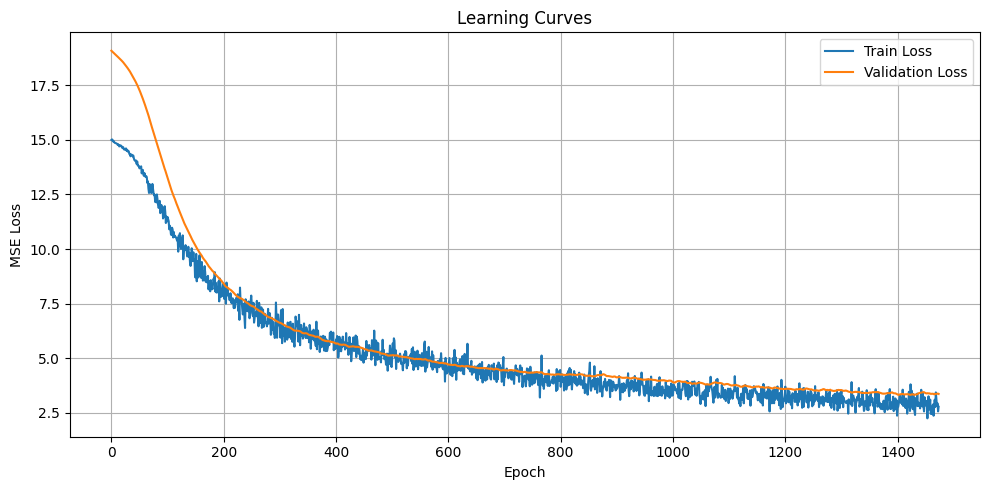

Train MAPE: 5032256181303.1729, Test MAPE: 2.1753
Train MSE: 1.7162, Test MSE: 22.4598
Restored train MAPE: 0.0131
Restored test MAPE: 0.0532
Restored train MSE: 1.7162
Restored test MSE: 22.4598


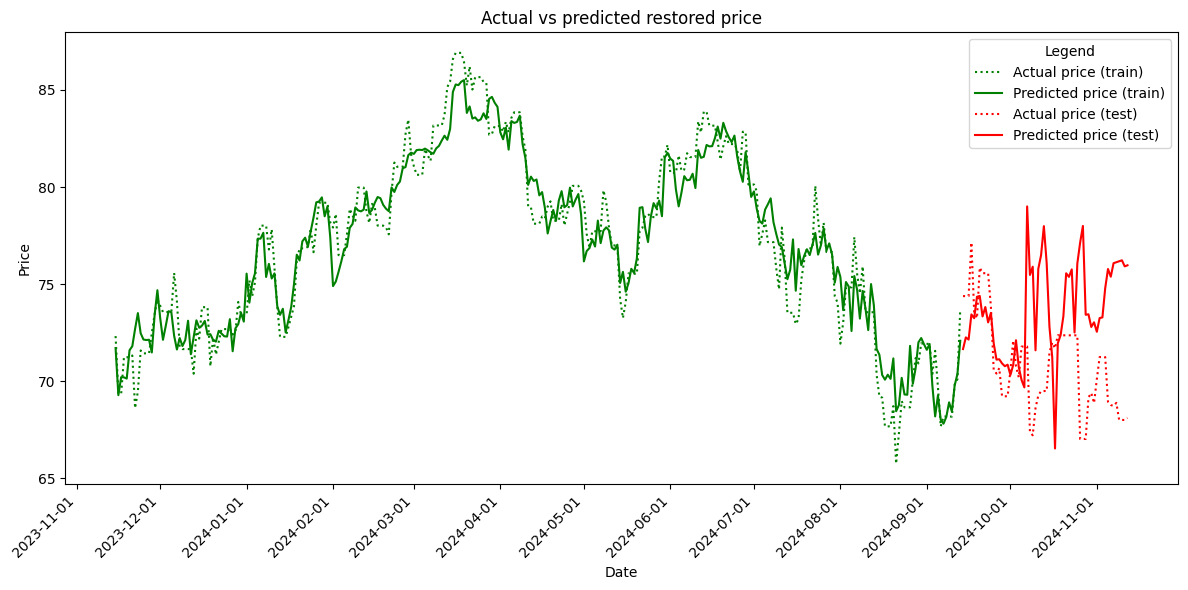

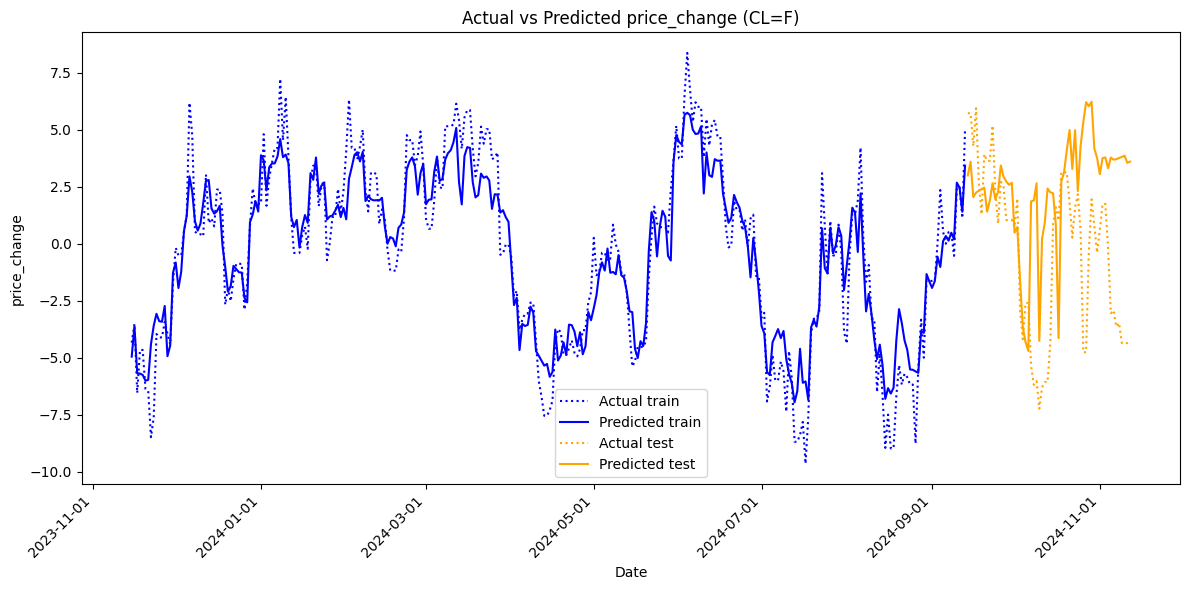

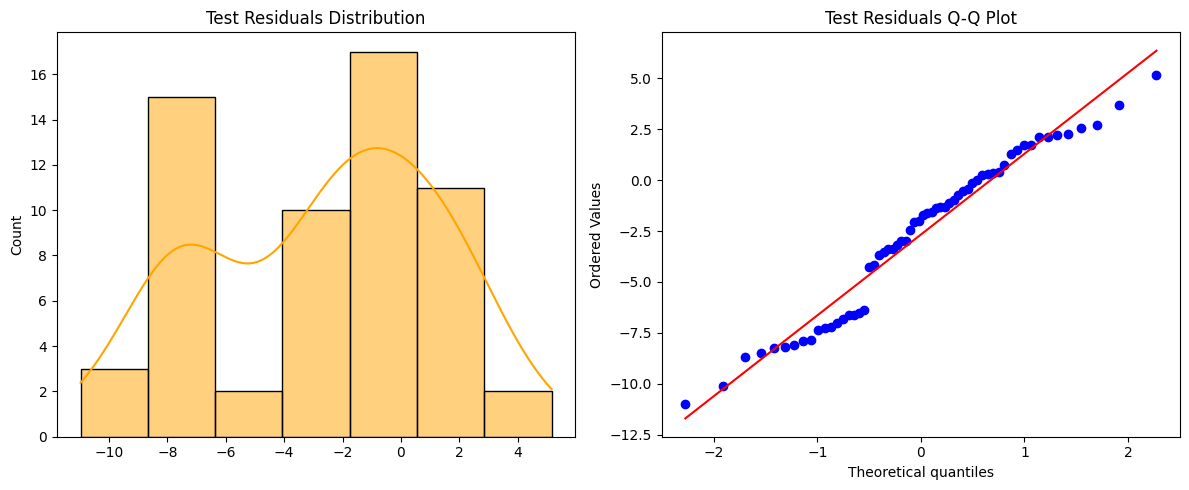

Shapiro-Wilk Test for Test Residuals: Statistic=0.9588, p-value=0.0413


In [432]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = all_combinations.drop(
    ['business_date', 'close', 'price_change','next_day_close'], 
    axis=1, 
    errors='ignore'
).select_dtypes(['int', 'float']).shape[1]

model = nn.Sequential(
    nn.Linear(input_dim, 32), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(32, 16), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(16, 1)
).to(device)

model, scaler, feature_names = run_model(
    target='price_change',
    ticker_name='CL=F',
    test_len=60,
    to_delete=['business_date', 'close', 'price_change','next_day_close'],
    model=model,
    shift_days=20,
    all_combinations=all_combinations,
    epochs=20000,
    batch_size=32,
    lr=1e-4,
    patience = 50
)


### Выводы по MLP
График изменения цены (price_change): В тренировочной части мы видим хорошее попадание, даже объясняются некоторые пики, но есть целый интервал сильных отклонений. На тесте мы наблюдаем значительные колебания, не совпадающие с основным трендом. 
График восстановленной цены: Такое же хорошее попадание на трейне и на тесте, несмотря на то, что общий тренд снижения цены, прогноз, хоть и с выраженным шумом, направлен вверх. Несмотря на совпадающие кривые обучения, на трейне модель себя ведет более устойчиво. 

Такая особенность наблюдается и по показателям метрик MSE (train 1.6 и test 21.8) и MAPE (train 0.01 и test 0.05).

### Часть первая. Трансформер

In [8]:

# выведем класс позиционного кодирования отдельно от самого трансформера
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# теперь можем описать трансформер и вставить позиционное кодирование
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=1, dropout=0.1):
        super().__init__()
        self.input_lin = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_lin = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_lin(x)
        x = self.pos_enc(x)
        x = self.transformer(x)
        return self.output_lin(x[:, -1, :])


def run_transformer_model(
    target, ticker_name, model, test_len, to_delete, shift_days,
    all_combinations, sequence_length=20,
    epochs=100, batch_size=32, lr=1e-4, patience=10
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    df = all_combinations.loc[all_combinations.ticker == ticker_name].ffill().copy()
    df['next_day_close'] = df['close'].shift(-shift_days)
    df['price_change'] = df['next_day_close'] - df['close']
    df = df.dropna().reset_index(drop=True)

    if target == 'price_change':
        y = df['price_change'].values
    elif target == 'next_day_close':
        y = df['next_day_close'].values
    else:
        raise ValueError("target must be 'price_change' or 'next_day_close'")

    X = df.drop(to_delete, axis=1, errors='ignore').select_dtypes(['int', 'float']).values
    dates = df.business_date

    def slide(X, y, L):
        xs, ys = [], []
        for i in range(len(X) - L):
            xs.append(X[i:i+L])
            ys.append(y[i+L])
        return np.array(xs), np.array(ys)

    X_seq, y_seq = slide(X, y, sequence_length)
    dates_seq = dates.iloc[sequence_length:].reset_index(drop=True)
    X_train_raw, X_test_raw = X_seq[:-test_len], X_seq[-test_len:]
    y_train, y_test = y_seq[:-test_len], y_seq[-test_len:]
    dates_train = dates_seq.iloc[:-test_len]
    dates_test  = dates_seq.iloc[-test_len:]

    # проводим нормализацию на плоских массивах
    n_feat = X.shape[1]
    scaler = StandardScaler()
    X_tr_flat = X_train_raw.reshape(-1, n_feat)
    X_te_flat = X_test_raw.reshape(-1, n_feat)
    X_tr_s = scaler.fit_transform(X_tr_flat).reshape(X_train_raw.shape)
    X_te_s = scaler.transform(X_te_flat).reshape(X_test_raw.shape)

    
    X_tr_t = torch.tensor(X_tr_s, dtype=torch.float32).to(device)
    y_tr_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
    X_te_t = torch.tensor(X_te_s, dtype=torch.float32).to(device)

    # дл] ранней остановки нужна валидационная выборка
    tr_size = int(0.8 * len(X_tr_t))
    val_size = len(X_tr_t) - tr_size
    tr_ds, val_ds = random_split(TensorDataset(X_tr_t, y_tr_t), [tr_size, val_size])
    tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # азпускаем обучение
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()
    best_val = float('inf')
    no_change = 0
    best_state = None
    hist = {'train_loss': [], 'val_loss': []}

    for ep in range(1, epochs+1):
        model.train()
        tr_loss = 0
        for xb, yb in tr_loader:
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * xb.size(0)
        tr_loss /= len(tr_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss += crit(model(xb), yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        hist['train_loss'].append(tr_loss)
        hist['val_loss'].append(val_loss)
        print(f"Epoch {ep}/{epochs}  Train: {tr_loss:.4f}  Val: {val_loss:.4f}")

        # ранняя остановка
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
            no_change = 0
        else:
            no_change += 1
            if no_change >= patience:
                print(f"Early stopping at epoch {ep}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # выводим график обучения
    plt.figure(figsize=(10,5))
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # сначала выведем метрики на том ряду, на той переменной, на которой обучали
    model.eval()
    with torch.no_grad():
        y_tr_pred = model(X_tr_t).cpu().numpy().flatten()
        y_te_pred = model(X_te_t).cpu().numpy().flatten()

    print(f"Train MSE: {mean_squared_error(y_train, y_tr_pred):.4f}, "
          f"Test MSE: {mean_squared_error(y_test,  y_te_pred):.4f}")
    print(f"Train MAPE: {mean_absolute_percentage_error(y_train, y_tr_pred):.4f}, "
          f"Test MAPE: {mean_absolute_percentage_error(y_test,  y_te_pred):.4f}")

    # и если мы предсказываем изменение цены, то восстановим фактическую цену
    if target == 'price_change':
        closes = df['close'].values
        train_closes = closes[sequence_length:sequence_length+len(y_train)]
        test_closes  = closes[-len(y_test):]
        rest_tr = train_closes + y_tr_pred
        rest_te = test_closes + y_te_pred
        print('close_price test MSE:', mean_squared_error(test_closes, rest_te))
        print('close_price test MAPE:', mean_absolute_percentage_error(test_closes, rest_te))
        print('close_price train MSE:', mean_squared_error(train_closes, rest_tr))
        print('close_price train MAPE:', mean_absolute_percentage_error(train_closes, rest_tr))
        plt.figure(figsize=(12,6))
        plt.plot(dates_train, rest_tr, label='Pred Price (train)', color='green')
        plt.plot(dates_train, df['next_day_close'].iloc[sequence_length:-test_len],
                 label='Actual Price (train)', linestyle='dotted', color='green')
        plt.plot(dates_test,  rest_te, label='Pred Price (test)', color='red')
        plt.plot(dates_test,  df['next_day_close'].iloc[-test_len:],
                 label='Actual Price (test)', linestyle='dotted', color='red')
        plt.xlabel('Date'); plt.ylabel('Price'); plt.legend(); plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));
        plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    
    plt.figure(figsize=(12,6))
    plt.plot(dates_train, y_train,     linestyle='dotted', color='blue',  label='Actual train')
    plt.plot(dates_train, y_tr_pred,   color='blue',               label='Pred train')
    plt.plot(dates_test,  y_test,      linestyle='dotted', color='orange',label='Actual test')
    plt.plot(dates_test,  y_te_pred,   color='orange',             label='Pred test')
    plt.xlabel('Date'); plt.ylabel(target); plt.legend(); plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    # посмотрим на остатки
    res = y_test - y_te_pred
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    sns.histplot(res, kde=True, ax=ax[0], color='orange'); ax[0].set_title('Test Residuals')
    stats.probplot(res, dist='norm', plot=ax[1]); ax[1].set_title('Q-Q Plot')
    plt.tight_layout(); plt.show()

    shp = stats.shapiro(res)
    print(f"Shapiro-Wilk: stat={shp.statistic:.4f}, p={shp.pvalue:.4f}")

    # 14) Return
    feat_names = df.drop(to_delete, axis=1, errors='ignore').select_dtypes(['int','float']).columns.tolist()
    return model, scaler, feat_names


Epoch 1/100  Train: 13.7692  Val: 18.0954
Epoch 2/100  Train: 12.4999  Val: 17.8381
Epoch 100/100  Train: 2.0528  Val: 3.3353


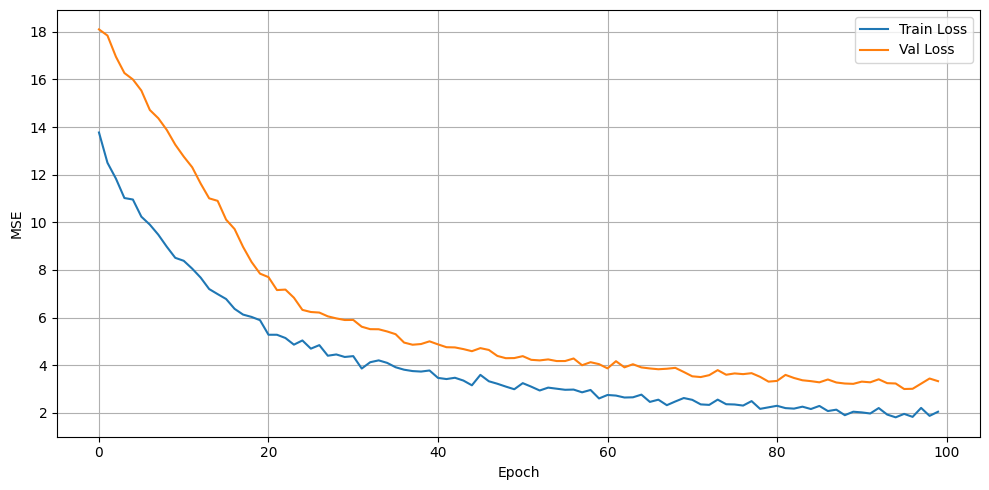

Train MSE: 1.8734, Test MSE: 19.4319
Train MAPE: 1688595126360.1145, Test MAPE: 1.7341
close_price test MSE: 3.5718802946226753
close_price test MAPE: 0.02174422645088725
close_price train MSE: 13.614911450517942
close_price train MAPE: 0.04103608013671804


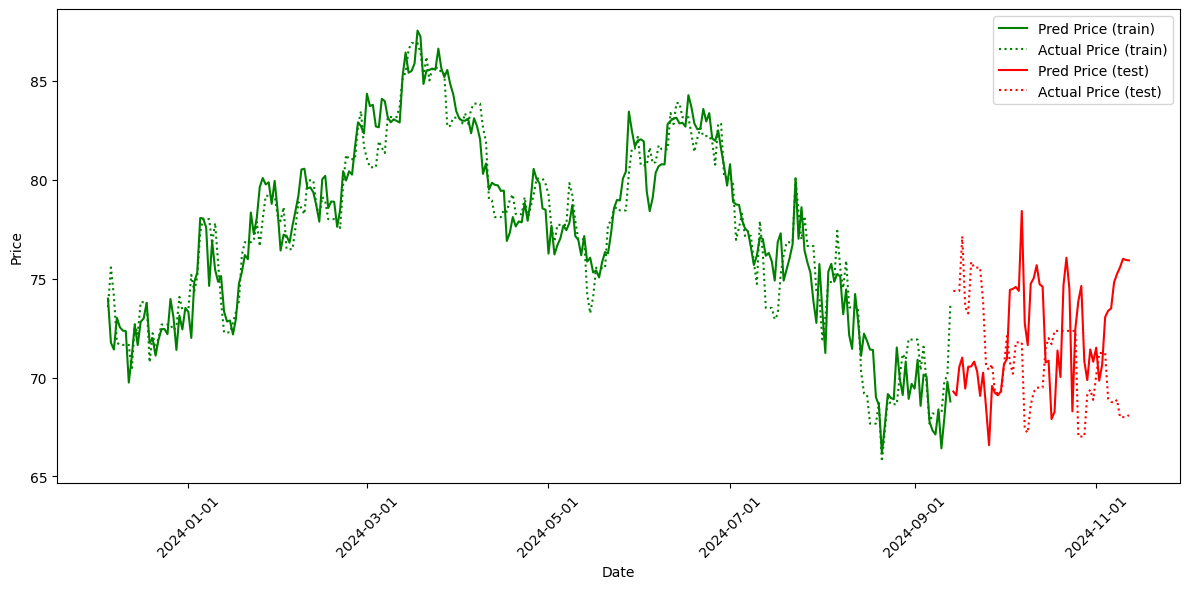

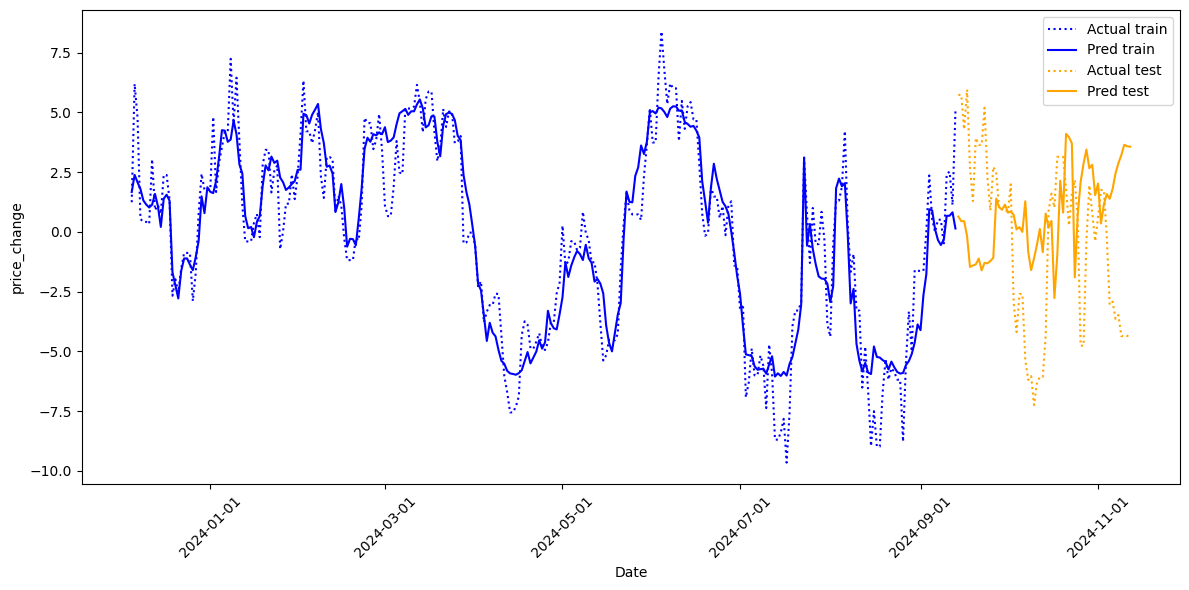

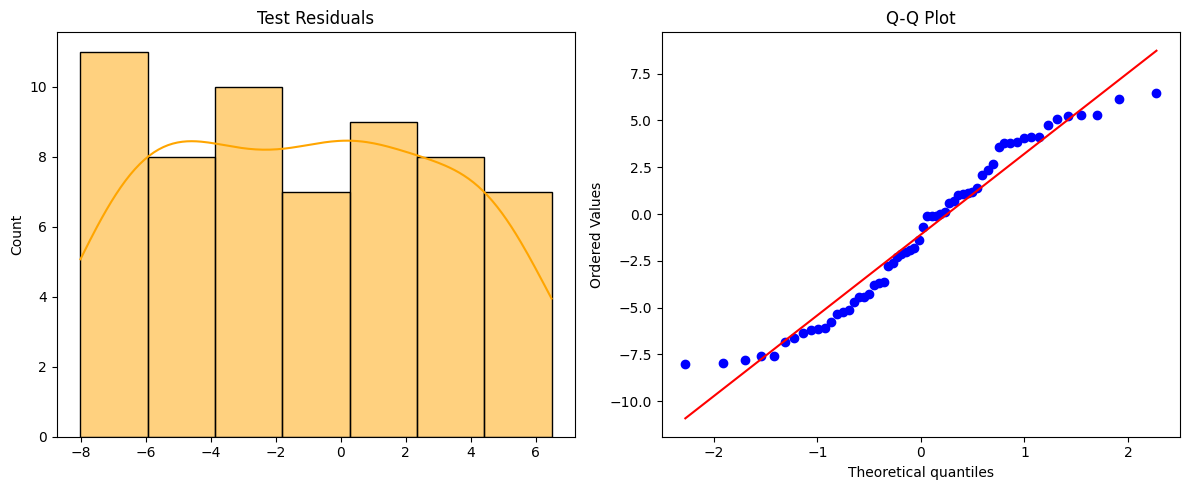

Shapiro-Wilk: stat=0.9494, p=0.0146


In [443]:
shift_days = 20

df = all_combinations.loc[all_combinations.ticker == 'CL=F'].ffill().copy()
df['next_day_close'] = df['close'].shift(-shift_days)
df['price_change'] = df['next_day_close'] - df['close']
df = df.dropna().reset_index(drop=True)


to_delete = ['business_date','close','price_change','next_day_close']
X_tmp = df.drop(to_delete, axis=1, errors='ignore')\
          .select_dtypes(['int','float'])

input_dim = X_tmp.shape[1]
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.1
)

model, scaler, feature_names = run_transformer_model(
    target='price_change',
    ticker_name='CL=F',
    model=model,
    test_len=60,
    to_delete=to_delete,
    shift_days=shift_days,
    all_combinations=all_combinations,
    sequence_length=20,
    epochs=100,
    batch_size=32,
    lr=1e-4,
    patience=30
)

### Выводы по Transformer
График изменения цены: Transformer Показывает более гладкий временной ряд, лучше попадает в экстремумы. На трейне пропали участки сильных непопаданий, хотя  на тесте они все еще наблюдается (так и не удалось распознать резкое снижение в середине тестового участка), однако в данном случае прогноз не устремляется вверх.

График восстановленной цены: На трейне еще более точные попадания, чем в трехслойной модели. На тесте все еще наблюдается увеличение ошибки, несовпадает амплитуда, присутствует шум, но уже в меньшей степени. Это подтверждается и метриками, на тесте удолось достичь MSE 2.87 и MAPE 0.019 


Попробуем теперь той же архитектурой предсказывать не изменения цены, а фактическую цену.


Epoch 1/2000  Train: 5971.0162  Val: 5661.2325
Epoch 2/2000  Train: 5758.9052  Val: 5490.1100
Epoch 3/2000  Train: 5619.6543  Val: 5380.0598
Epoch 4/2000  Train: 5535.1923  Val: 5312.4803
Epoch 1113/2000  Train: 2.1160  Val: 2.4829
Epoch 1114/2000  Train: 1.7209  Val: 2.2495
Epoch 1115/2000  Train: 1.7580  Val: 2.4276
Epoch 1116/2000  Train: 1.8103  Val: 2.2931
Early stopping at epoch 1116


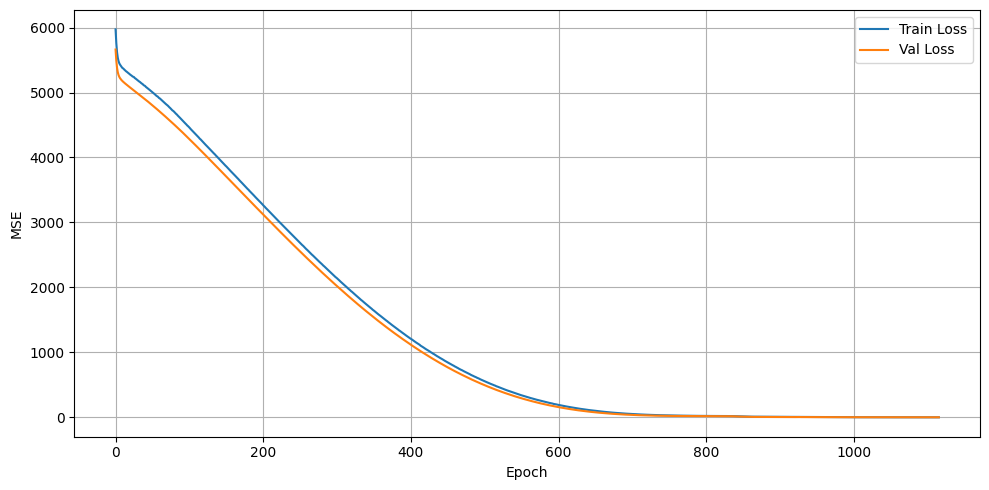

Train MSE: 1.6682, Test MSE: 22.5933
Train MAPE: 0.0125, Test MAPE: 0.0542


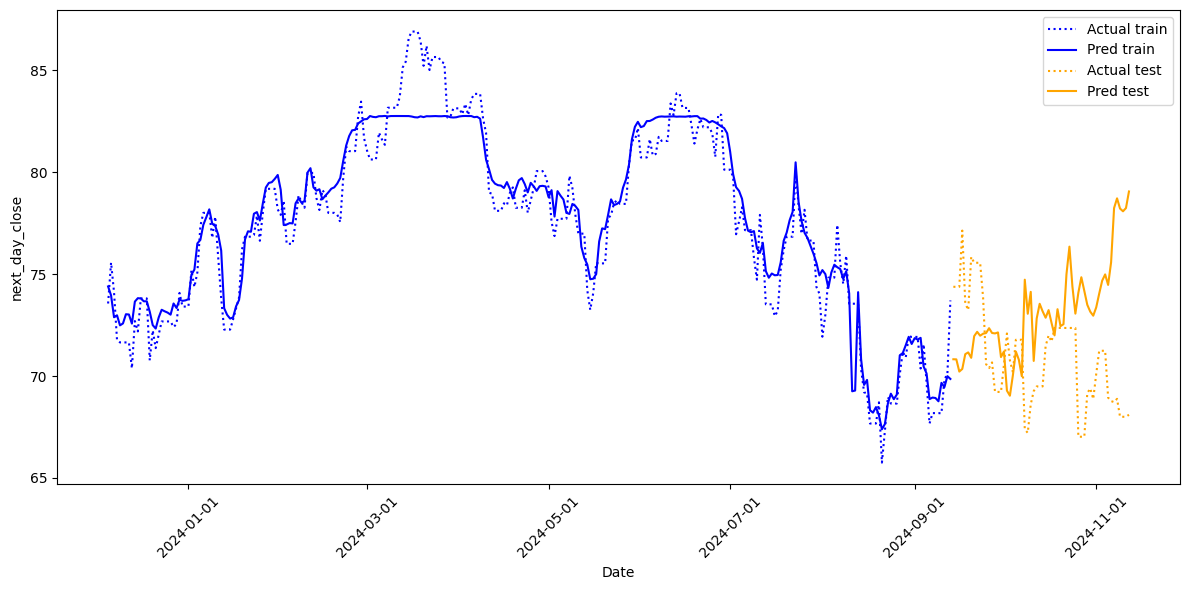

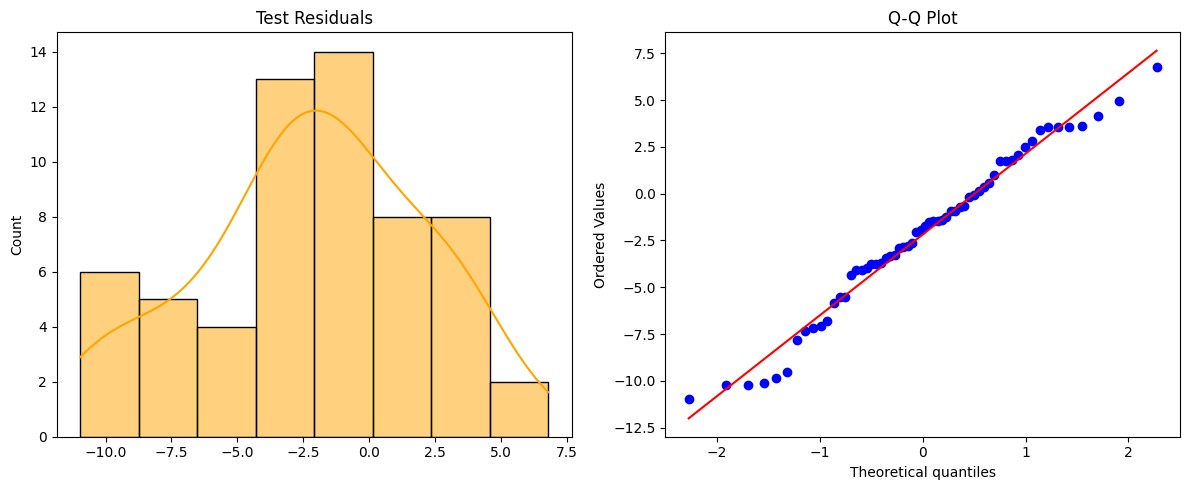

Shapiro-Wilk: stat=0.9767, p=0.3058


In [ ]:
shift_days = 20

df = all_combinations.loc[all_combinations.ticker == 'CL=F'].ffill().copy()
df['next_day_close'] = df['close'].shift(-shift_days)
df['price_change'] = df['next_day_close'] - df['close']
df = df.dropna().reset_index(drop=True)


to_delete = ['business_date','close','price_change','next_day_close']
X_tmp = df.drop(to_delete, axis=1, errors='ignore')\
          .select_dtypes(['int','float'])

input_dim = X_tmp.shape[1]
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.1
)

model, scaler, feature_names = run_transformer_model(
    target='next_day_close',
    ticker_name='CL=F',
    model=model,
    test_len=60,
    to_delete=to_delete,
    shift_days=shift_days,
    all_combinations=all_combinations,
    sequence_length=20,
    epochs=2000,
    batch_size=32,
    lr=1e-4,
    patience=30
)

При обучении трансформера на фактические цены, а не изменения цены, мы видим то, что предсказания становятся более сглаженными, появляются периоды сильного непопадания в пиковые значения. Также модель снова показывает себя хуже на тесте. Мы получили увеличение MAPE в 2,5 раза и MSE почти в 10 раз.

Теперь попробуем применить к тому же временному ряду N-BEATS

In [9]:
# оч сильно переобучается, поэтому после каждого слоя добавляем dropout
class NBeatsBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, backcast_size, forecast_size, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.do1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.do2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.do3 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.do4 = nn.Dropout(dropout)
        self.backcast = nn.Linear(hidden_dim, backcast_size)
        self.forecast = nn.Linear(hidden_dim, forecast_size)

    def forward(self, x):
        h = torch.relu(self.do1(self.fc1(x)))
        h = torch.relu(self.do2(self.fc2(h)))
        h = torch.relu(self.do3(self.fc3(h)))
        h = torch.relu(self.do4(self.fc4(h)))
        b = self.backcast(h)
        f = self.forecast(h)
        return b, f


class NBeats(nn.Module):
    def __init__(self, backcast_size, forecast_size, nb_blocks_per_stack=3, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(
                input_dim=backcast_size,
                hidden_dim=hidden_dim,
                backcast_size=backcast_size,
                forecast_size=forecast_size,
                dropout=dropout
            )
            for _ in range(nb_blocks_per_stack)
        ])

    def forward(self, x):
        residual = x
        forecast = torch.zeros(x.size(0), self.blocks[0].forecast.out_features, device=x.device)
        for block in self.blocks:
            b, f = block(residual)
            residual = residual - b
            forecast = forecast + f
        return forecast


def run_nbeats(
    target, ticker_name, model, test_len, to_delete, shift_days,
    all_combinations, sequence_length=20,
    epochs=100, batch_size=32, lr=1e-4, patience=10
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    df = all_combinations.loc[all_combinations.ticker == ticker_name].ffill().copy()
    df['next_day_close'] = df['close'].shift(-shift_days)
    df['price_change']    = df['next_day_close'] - df['close']
    df = df.dropna().reset_index(drop=True)


    if target == 'price_change':
        y = df['price_change'].values
    elif target == 'next_day_close':
        y = df['next_day_close'].values
    else:
        raise ValueError("target must be 'price_change' or 'next_day_close'")

    X = df.drop(to_delete, axis=1, errors='ignore').select_dtypes(['int', 'float']).values
    dates = df.business_date

    # здесь помимо слайда надо сделать флаттен, чтобы соответствовать архитектуре
    def slide(X, y, L):
        xs, ys = [], []
        for i in range(len(X) - L):
            window = X[i:i+L].flatten()
            xs.append(window)
            ys.append(y[i+L])
        return np.array(xs), np.array(ys)

    X_seq, y_seq = slide(X, y, sequence_length)
    dates_seq = dates.iloc[sequence_length:].reset_index(drop=True)


    X_train_raw, X_test_raw = X_seq[:-test_len], X_seq[-test_len:]
    y_train, y_test = y_seq[:-test_len], y_seq[-test_len:]
    dates_train = dates_seq.iloc[:-test_len]
    dates_test = dates_seq.iloc[-test_len:]

    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_train_raw)
    X_te_s = scaler.transform(X_test_raw)


    X_tr_t = torch.tensor(X_tr_s, dtype=torch.float32).to(device)
    y_tr_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
    X_te_t = torch.tensor(X_te_s, dtype=torch.float32).to(device)

    tr_size = int(0.8 * len(X_tr_t))
    val_size = len(X_tr_t) - tr_size
    tr_ds, val_ds = random_split(TensorDataset(X_tr_t, y_tr_t), [tr_size, val_size])
    tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    no_improve = 0
    best_state = None
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for xb, yb in tr_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(tr_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss += criterion(model(xb), yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    plt.figure(figsize=(10,5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'],   label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    model.eval()
    with torch.no_grad():
        y_tr_pred = model(X_tr_t).cpu().numpy().flatten()
        y_te_pred = model(X_te_t).cpu().numpy().flatten()

    train_mse = mean_squared_error(y_train, y_tr_pred)
    test_mse  = mean_squared_error(y_test,  y_te_pred)
    train_mape= mean_absolute_percentage_error(y_train, y_tr_pred)
    test_mape = mean_absolute_percentage_error(y_test,  y_te_pred)

    print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"Train MAPE: {train_mape:.4f}, Test MAPE: {test_mape:.4f}")

    if target == 'price_change':
        actual_tr = df['next_day_close'].iloc[sequence_length:-test_len].values
        actual_te = df['next_day_close'].iloc[-test_len:].values
        base_tr   = df['close'].iloc[sequence_length:-test_len].values
        base_te   = df['close'].iloc[-test_len:].values
        rest_tr   = base_tr + y_tr_pred
        rest_te   = base_te + y_te_pred

        restored_train_mse  = mean_squared_error(actual_tr, rest_tr)
        restored_test_mse   = mean_squared_error(actual_te, rest_te)
        restored_train_mape = mean_absolute_percentage_error(actual_tr, rest_tr)
        restored_test_mape  = mean_absolute_percentage_error(actual_te, rest_te)
        print(f"Restored train MAPE: {restored_train_mape:.4f}")
        print(f"Restored test MAPE:  {restored_test_mape:.4f}")
        print(f"Restored train MSE:  {restored_train_mse:.4f}")
        print(f"Restored test MSE:   {restored_test_mse:.4f}")

        dates_rest_tr = dates_train
        dates_rest_te = dates_test
        plt.figure(figsize=(12,6))
        plt.plot(dates_rest_tr, actual_tr, label='Actual Price (train)', color='green', linestyle='dotted')
        plt.plot(dates_rest_tr, rest_tr,   label='Predicted Price (train)', color='green')
        plt.plot(dates_rest_te, actual_te, label='Actual Price (test)',  color='red',   linestyle='dotted')
        plt.plot(dates_rest_te, rest_te,   label='Predicted Price (test)', color='red')
        plt.title('Actual vs Predicted Restored Price')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.gcf().autofmt_xdate(rotation=45)
        plt.tight_layout()
        plt.show()

   
    plt.figure(figsize=(12,6))
    plt.plot(dates_train, y_train,    label='Actual train', linestyle='dotted', color='blue')
    plt.plot(dates_train, y_tr_pred,  label='Predicted train', color='blue')
    plt.plot(dates_test,  y_test,     label='Actual test', linestyle='dotted', color='orange')
    plt.plot(dates_test,  y_te_pred,  label='Predicted test', color='orange')
    plt.title(f"Actual vs Predicted {target} ({ticker_name})")
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gcf().autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()


    residuals = y_test - y_te_pred
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(residuals, bins=30, kde=True, ax=axes[0], color='orange')
    axes[0].set_title('Test Residuals Distribution')
    stats.probplot(residuals, dist='norm', plot=axes[1])
    axes[1].set_title('Test Residuals Q-Q Plot')
    plt.tight_layout()
    plt.show()

    shapiro_test = stats.shapiro(residuals)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")

    
    feat_names = df.drop(to_delete, axis=1, errors='ignore').select_dtypes(['int', 'float']).columns.tolist()
    return model, scaler, feat_names



Epoch 1/200, Train Loss: 16.019640, Val Loss: 13.506906
Epoch 2/200, Train Loss: 15.861817, Val Loss: 13.415431
Epoch 3/200, Train Loss: 15.855278, Val Loss: 13.318253
Epoch 196/200, Train Loss: 1.469349, Val Loss: 2.280258
Epoch 197/200, Train Loss: 1.498794, Val Loss: 2.277081
Epoch 198/200, Train Loss: 1.590868, Val Loss: 2.297819
Epoch 199/200, Train Loss: 1.546345, Val Loss: 2.268360
Epoch 200/200, Train Loss: 1.477992, Val Loss: 2.224776


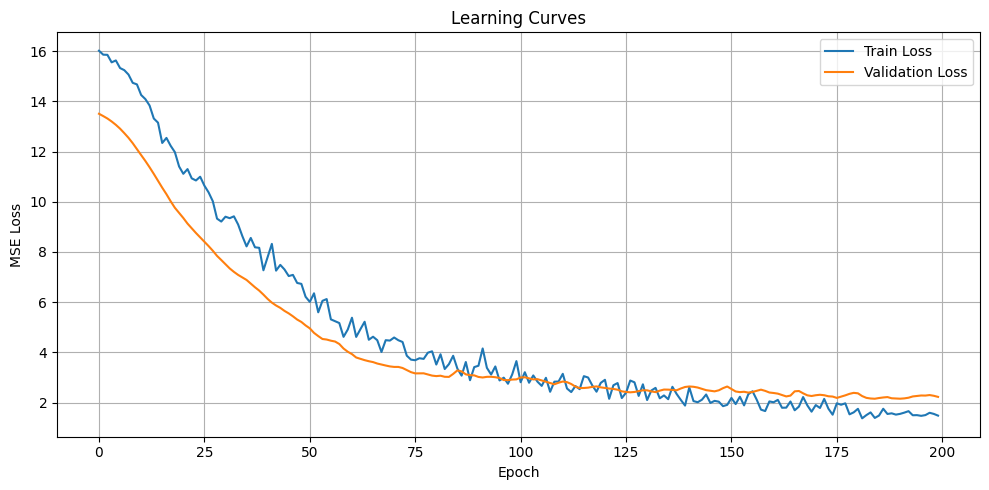

Train MSE: 0.9525, Test MSE: 22.9033
Train MAPE: 1406515776671.3845, Test MAPE: 2.3118
Restored train MAPE: 0.0092
Restored test MAPE:  0.0612
Restored train MSE:  0.9525
Restored test MSE:   22.9033


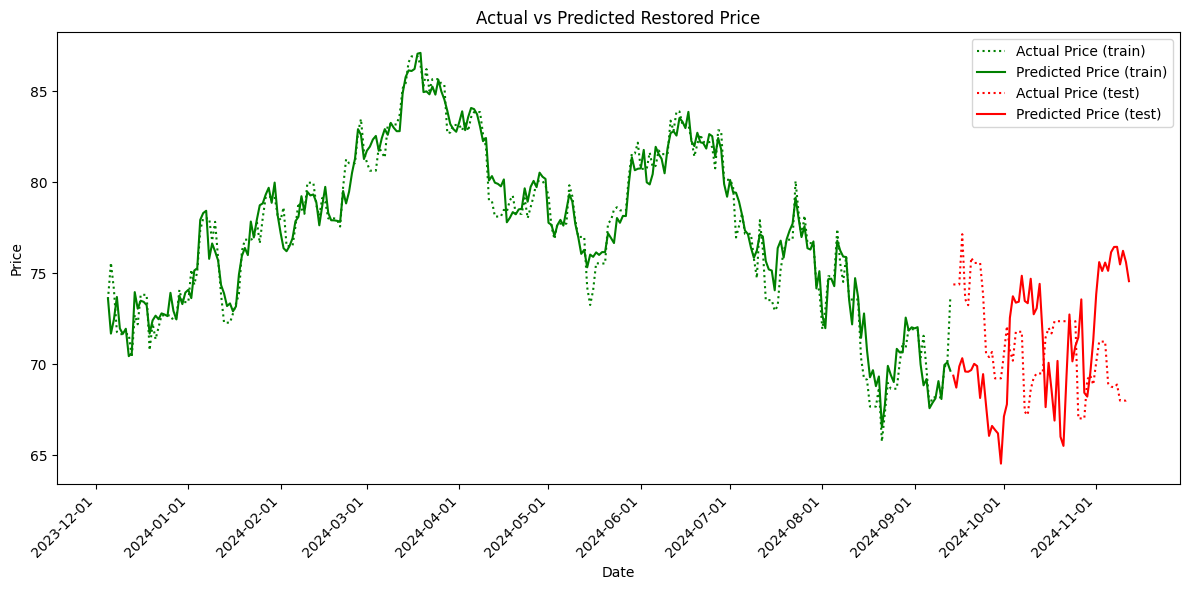

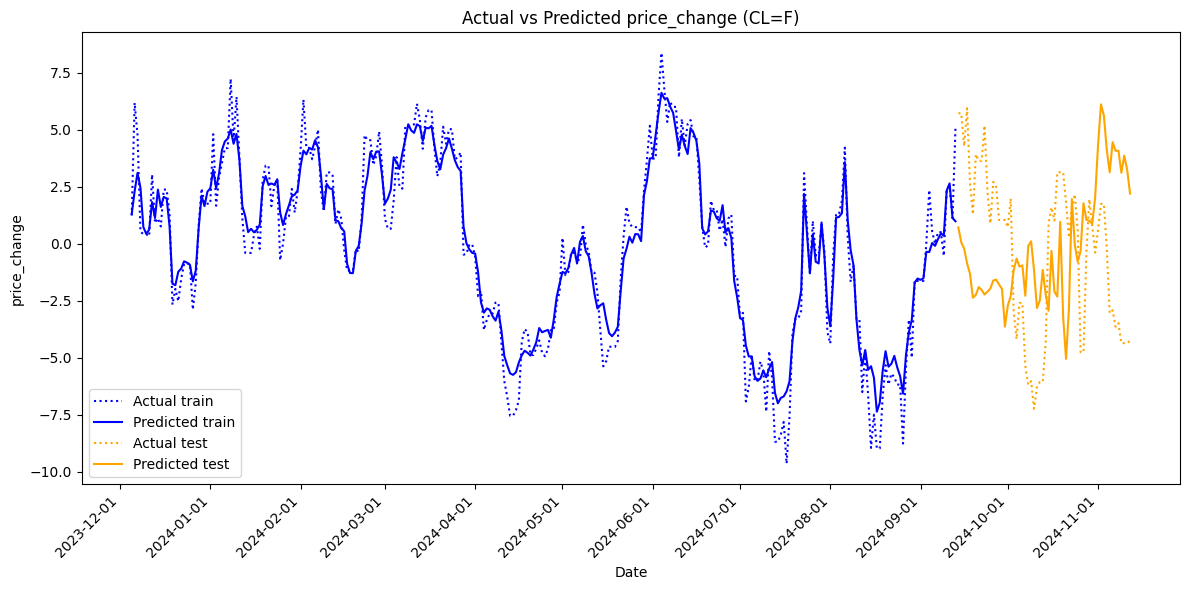

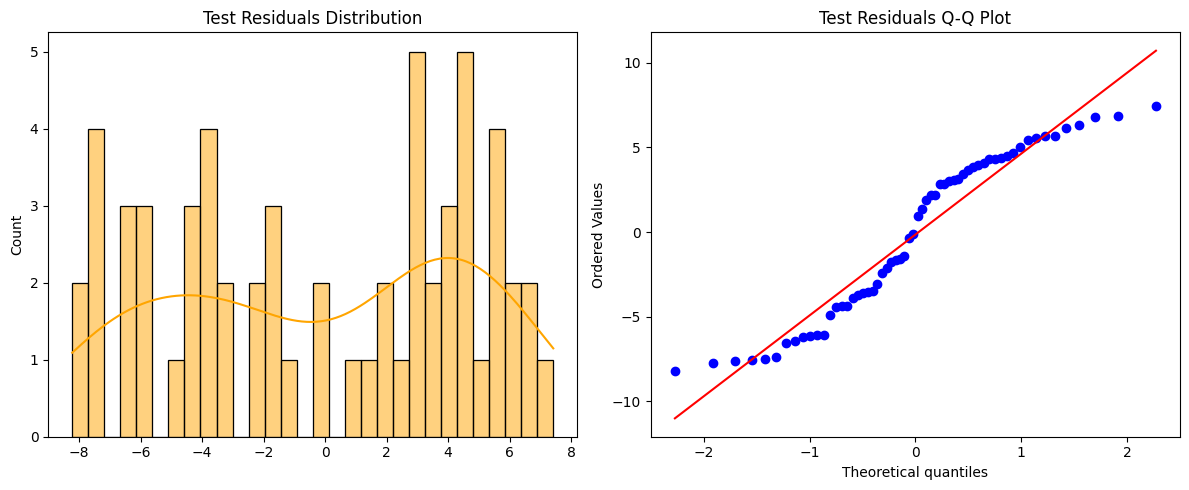

Shapiro-Wilk Test: Statistic=0.9225, p-value=0.0010


In [438]:
sequence_length = 20
n_features = all_combinations.drop(
    ['business_date','close','price_change','next_day_close'],
    axis=1,errors='ignore'
).select_dtypes(['int','float']).shape[1]

backcast_size = sequence_length * n_features  # например, 20*59=1180


model = NBeats(
    backcast_size=backcast_size,
    forecast_size=1,
    nb_blocks_per_stack=3,
    hidden_dim=32,
    dropout=0.3
)

model, scaler, feature_names = run_nbeats(
    target='price_change',
    ticker_name='CL=F',
    model=model,
    test_len=60,
    to_delete=['business_date','close','price_change','next_day_close'],
    shift_days=20,
    all_combinations=all_combinations,
    sequence_length=sequence_length,
    epochs=200,
    batch_size=32,
    lr=1e-4,
    patience=30
)

###  N-BEATS Выводы
Похоже что N Beats значительно быстрее обучается иили по крайней мере запоминает трейн. Но на тесте от этой модели не удалось добиться более высокого результата. По мере увеличения сложности модель все больше показывает переобучение, в то же время низкая сложность или увеличение влияния дропаут слоев приводило к уменьшению точности на трейне без увеличения точности в тестовой части.

Частично это было ожидаемо, т.к. мы изначально не использовали внутридневные показатели и брали только цену закрытия, получая только одну запись на 1 день. А все необходимые признаки извлекли и предобработали заранее, что не требуется для этой архитектуры

In [10]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout if num_layers>1 else 0.0,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


def run_lstm_model(
    target, ticker_name, model, test_len, to_delete, shift_days,
    all_combinations, sequence_length=20,
    epochs=100, batch_size=32, lr=1e-4, patience=10
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    df = all_combinations.loc[all_combinations.ticker==ticker_name].ffill().copy()
    df['next_day_close'] = df['close'].shift(-shift_days)
    df['price_change']    = df['next_day_close'] - df['close']
    df = df.dropna().reset_index(drop=True)

    if target=='price_change':
        y = df['price_change'].values
    elif target=='next_day_close':
        y = df['next_day_close'].values
    else:
        raise ValueError("target must be 'price_change' or 'next_day_close'")

    feats = df.drop(to_delete, axis=1, errors='ignore')\
             .select_dtypes(['int','float'])
    X = feats.values
    feature_names = feats.columns.tolist()
    dates = df.business_date

    def slide(X, y, L):
        xs, ys = [], []
        for i in range(len(X)-L):
            xs.append(X[i:i+L])
            ys.append(y[i+L])
        return np.array(xs), np.array(ys)

    X_seq, y_seq = slide(X, y, sequence_length)
    dates_seq    = dates.iloc[sequence_length:].reset_index(drop=True)

    X_tr_raw, X_te_raw = X_seq[:-test_len], X_seq[-test_len:]
    y_tr,      y_te    = y_seq[:-test_len], y_seq[-test_len:]
    dates_tr = dates_seq.iloc[:-test_len]
    dates_te = dates_seq.iloc[-test_len:]

    dates_train = dates_tr
    dates_test  = dates_te

    n_feat = X.shape[1]
    scaler = StandardScaler()
    X_tr_flat = X_tr_raw.reshape(-1, n_feat)
    X_te_flat = X_te_raw.reshape(-1, n_feat)
    X_tr_s = scaler.fit_transform(X_tr_flat).reshape(X_tr_raw.shape)
    X_te_s = scaler.transform(X_te_flat).reshape(X_te_raw.shape)

    X_tr_t = torch.tensor(X_tr_s, dtype=torch.float32).to(device)
    y_tr_t = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(1).to(device)
    X_te_t = torch.tensor(X_te_s, dtype=torch.float32).to(device)

    tr_size = int(0.8 * len(X_tr_t))
    val_size= len(X_tr_t) - tr_size
    tr_ds, val_ds = random_split(TensorDataset(X_tr_t, y_tr_t), [tr_size, val_size])
    tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    val_loader= DataLoader(val_ds, batch_size=batch_size)

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float('inf'); no_change=0; best_sm=None
    history = {'train_loss':[], 'val_loss':[]}

    for ep in range(1, epochs+1):
        model.train(); train_loss=0
        for xb,yb in tr_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward(); optimizer.step()
            train_loss += loss.item()*xb.size(0)
        train_loss /= len(tr_loader.dataset)

        model.eval(); val_loss=0
        with torch.no_grad():
            for xb,yb in val_loader:
                val_loss += criterion(model(xb), yb).item()*xb.size(0)
        val_loss /= len(val_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f"Epoch {ep}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_val:
            best_val=val_loss; no_change=0; best_sm=model.state_dict()
        else:
            no_change+=1
            if no_change>=patience:
                print(f"Early stopping at epoch {ep}")
                break

    if best_sm: model.load_state_dict(best_sm)


    plt.figure(figsize=(10,5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'],   label='Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
    plt.title('Learning Curves'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


    model.eval()
    with torch.no_grad():
        y_tr_pred = model(X_tr_t).cpu().numpy().flatten()
        y_te_pred = model(X_te_t).cpu().numpy().flatten()
    print(f"Train MSE: {mean_squared_error(y_tr, y_tr_pred):.4f}, Test MSE: {mean_squared_error(y_te, y_te_pred):.4f}")
    print(f"Train MAPE: {mean_absolute_percentage_error(y_tr, y_tr_pred):.4f}, Test MAPE: {mean_absolute_percentage_error(y_te, y_te_pred):.4f}")

    if target=='price_change':
        actual_tr = df['next_day_close'].iloc[sequence_length:-test_len].values
        actual_te = df['next_day_close'].iloc[-test_len:].values
        base_tr   = df['close'].iloc[sequence_length:-test_len].values
        base_te   = df['close'].iloc[-test_len:].values
        rest_tr   = base_tr + y_tr_pred
        rest_te   = base_te + y_te_pred
        print(f"Restored test MSE: {mean_squared_error(actual_te,rest_te):.4f}")
        print(f"Restored test MAPE: {mean_absolute_percentage_error(actual_te,rest_te):.4f}")
        print(f"Restored train MSE: {mean_squared_error(actual_tr,rest_tr):.4f}")
        print(f"Restored train MAPE: {mean_absolute_percentage_error(actual_tr,rest_tr):.4f}")
        plt.figure(figsize=(12,6))
        plt.plot(dates_train, actual_tr, label='Actual Price (train)', color='green', linestyle='dotted')
        plt.plot(dates_train, rest_tr,   label='Predicted Price (train)', color='green')
        plt.plot(dates_test,  actual_te, label='Actual Price (test)',  color='red',   linestyle='dotted')
        plt.plot(dates_test,  rest_te,   label='Predicted Price (test)', color='red')
        plt.title('Actual vs Predicted Restored Price')
        plt.xlabel('Date'); plt.ylabel('Price'); plt.legend();
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1));
        plt.gcf().autofmt_xdate(rotation=45); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(dates_train, y_tr,    linestyle='dotted', color='blue',  label='Actual train')
    plt.plot(dates_train, y_tr_pred,color='blue',                label='Pred train')
    plt.plot(dates_test,  y_te,    linestyle='dotted', color='orange',label='Actual test')
    plt.plot(dates_test,  y_te_pred,color='orange',              label='Pred test')
    plt.title(f"Actual vs Predicted {target} ({ticker_name})")
    plt.xlabel('Date'); plt.ylabel(target); plt.legend();
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1));
    plt.gcf().autofmt_xdate(rotation=45); plt.tight_layout(); plt.show()

    res = y_te - y_te_pred
    fig, ax = plt.subplots(1,2,figsize=(12,5));
    sns.histplot(res,kde=True,ax=ax[0],color='orange'); ax[0].set_title('Test Residuals')
    stats.probplot(res,dist='norm',plot=ax[1]); ax[1].set_title('Q-Q Plot'); plt.tight_layout(); plt.show()
    print(f"Shapiro-Wilk Test: stat={stats.shapiro(res).statistic:.4f}, p={stats.shapiro(res).pvalue:.4f}")

    return model, scaler, feature_names


Epoch 1/200, Train Loss: 15.533945, Val Loss: 13.759688
Epoch 2/200, Train Loss: 14.315322, Val Loss: 12.171825
Epoch 3/200, Train Loss: 12.026853, Val Loss: 10.218072
Epoch 4/200, Train Loss: 9.754617, Val Loss: 8.726072
Epoch 66/200, Train Loss: 0.970996, Val Loss: 1.914759
Epoch 67/200, Train Loss: 0.934614, Val Loss: 1.891678
Epoch 68/200, Train Loss: 0.945599, Val Loss: 1.876877
Early stopping at epoch 68


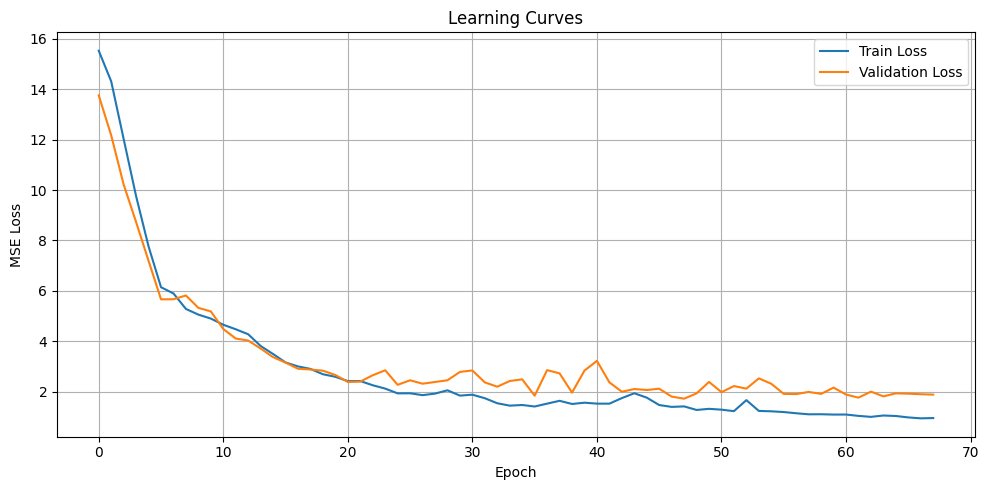

Train MSE: 1.0410, Test MSE: 28.7353
Train MAPE: 5778816586478.8525, Test MAPE: 2.1140
Restored test MSE: 28.7353
Restored test MAPE: 0.0594
Restored train MSE: 1.0410
Restored train MAPE: 0.0102


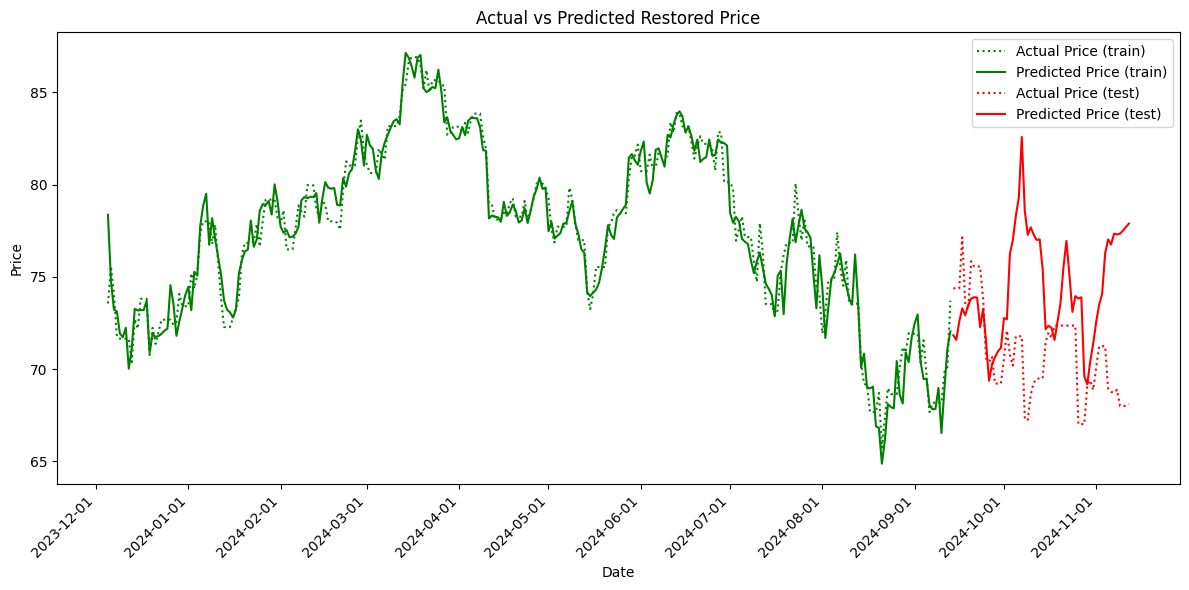

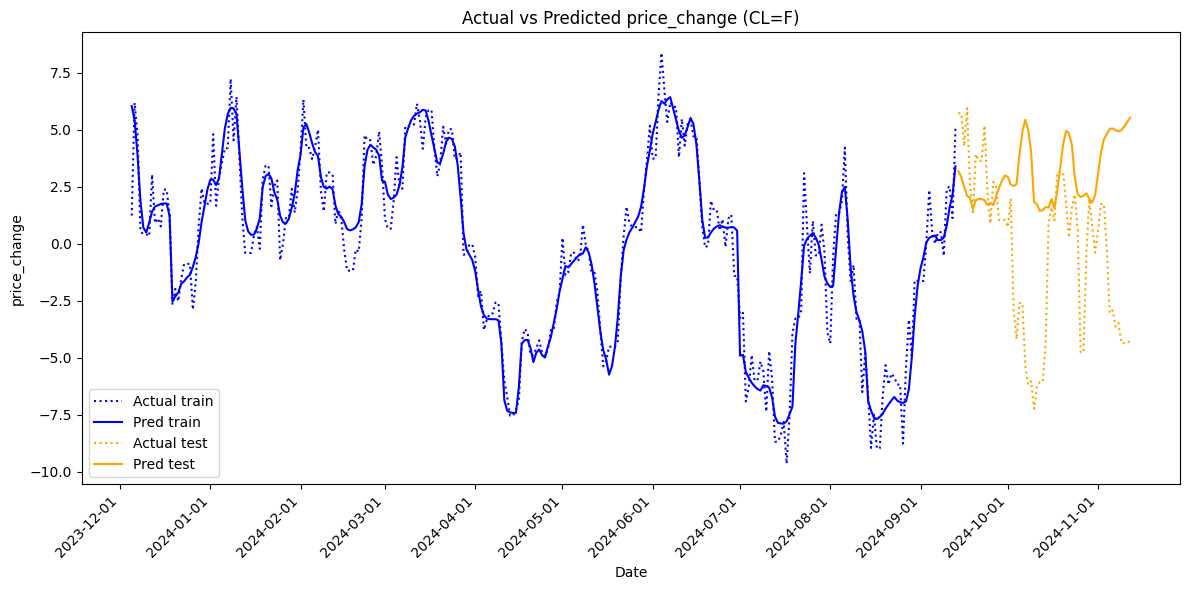

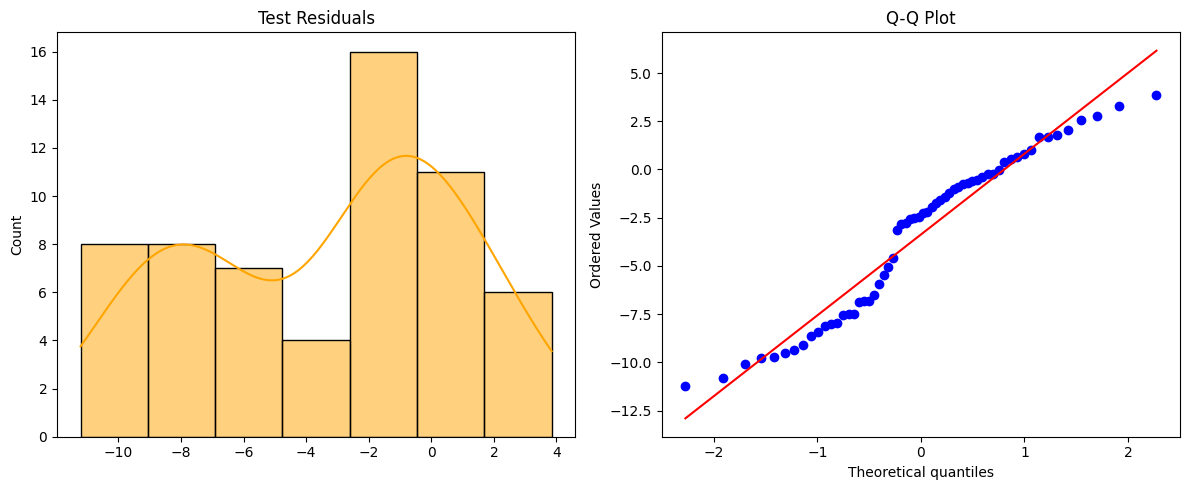

Shapiro-Wilk Test: stat=0.9407, p=0.0058


In [ ]:
sequence_length = 20
model = LSTMRegressor(
    input_dim = all_combinations.drop(
        ['business_date','close','price_change','next_day_close'], errors='ignore',
        axis=1
    ).select_dtypes(['int','float']).shape[1],
    hidden_dim = 64,
    num_layers = 2,
    dropout    = 0.2
)

model, scaler, feature_names = run_lstm_model(
    target = 'price_change', #'next_day_close'
    ticker_name = 'CL=F',
    model = model,
    test_len = 60,
    to_delete = ['business_date','close','price_change','next_day_close'],
    shift_days = 20,
    all_combinations = all_combinations,
    sequence_length = sequence_length,
    epochs = 200,
    batch_size = 32,
    lr = 1e-3,
    patience = 20
)

#### Выводы по LSTM

Модель хорошо запоминает тенировочную часть, но предсказывает на тесте значения в тех же масштабах, но предсказания выглядят случайными. Упрощение модели приводит к ухудшению на трейне, без увеличения качества на тесте.

### Общие выводы по всему процессу обучения.

Мы сравнили четыре архитектуры для построения прогноза на 20 дней вперёд, используя результаты линейной модели в качестве бейзлайна:

•	MLP — простая архитектура, без явного учёта временной зависимости

•	LSTM — для захвата последовательной структуры временных рядов

•	Transformer — для моделирования долгосрочных зависимостей с возможностью обрабатывать весь ряд целиком

•	N-BEATS — архитектура, ориентированная на классическое прогнозирование временных рядов, смещение акцента с регрессии на классический time series

Наилучшие результаты продемонстрировал трансформер. Остальные архитектуры показали сопоставимое качество, с небольшими отклонениями.


| Model       | Train MSE | Train MAPE | Test MSE | Test MAPE |
|-------------|-----------|------------|----------|-----------|
| MLP         | 1.7162    | 0.0131     | 22.4598  | 0.0532    |
| Transformer | 13.6149   | 0.0410     | 3.5719   | 0.0217    |
| LSTM        | 1.0410    | 0.0102     | 28.7353  | 0.0594    |
| N-BEATS     | 0.9525    | 0.0092     | 22.9033  | 0.0612    |

Далее представлены результаты для разных интервалов. В отличие от бейзлайна, мы можем сокращать горизонт прогнозирования и модели понимают колебания заметно лучше. Далее представлена таблица и графики для каждого из выбранных интервалов прогнозирования. Во всех случаях использовлась модель с архитектурой Transformer. 

| horizon (days) | train_MSE | train_MAPE | test_MSE | test_MAPE | comment                                                                 |
|----------------|-----------|------------|----------|-----------|-------------------------------------------------------------------------|
| 1              | 0.218     | 0.004      | 0.189    | 0.004     | не валидно, модель предсказывает слишком слабые отклонения цены, при сложении очень слабого отклонения с последней известной ценой получается практически наивный прогноз последнего известного значения|
| 3              | 2.612     | 0.017      | 1.421    | 0.013     | валидно, но проблема со слабой амплитудой предсказания, и наивным прогнозом еще не решена полностью, восстановленный ряд напоминает оригинальный ряд  с лагом |
| 5              | 5.935     | 0.026      | 5.028    | 0.027     | лучший результат, практически отсутствуют тренды в противоположном направлении, предсказывает отклонения с той же амплитудой что и в действительности, прогноз полностью перестает быть наивным. Появляется некоторый шум      |
| 10             | 9.091     | 0.033      | 6.841    | 0.030     | хороший результат, почти отсутствуют тренды в противоположном направлении, модель дает более "сглаженный" прогноз, немного не угадывает с амплитудой     |
| 15             | 11.851    | 0.037      | 2.746    | 0.019     | приемлемый результат, модель предсказывает все более "сглаженный" ряд, увеличивается проблема с амплитудой |
| 20             | 14.967    | 0.042      | 2.902    | 0.020     | все еще приемлемый результат, но ошибка растет, не все предсказания выглядят обоснованными|

### Итог

Среди всех опробованных архитектур лучше всего себя показала Transformer. Она дала наибольшую стабильность и точность при прогнозировании изменений цены. 

Среди способов делать прогноз большую стабильность и точность удалось достичь, прогнозируя отклонения цены и восстанавливая конечную цену сложением отклонения с последней известной ценой.

Из возможных горизонтов прогнозирования наибольшая чувствительность и наименьший шум достигается при прогнозе на 5 дней вперед. При слишком коротком горизонте модель чувствительна к шуму и случайным колебаниям. При слишком длинном — появляется проблема смещения.

### Распределение задач:

– Алексей, Александр занимались реализацией и обучением моделей MLP и Transformer, подготовкой графиков, а также выбором и обоснованием целевой переменной (прогноз изменения цены vs. абсолютной цены).

– Максим, Ксения работали с моделями LSTM и N-BEATS, проводили эксперименты с различными горизонтами прогнозирования и занимались анализом и описанием результатов.

Epoch 1/2000  Train: 1.3715  Val: 1.6609
Epoch 2/2000  Train: 1.2733  Val: 1.6126
Epoch 3/2000  Train: 1.1912  Val: 1.5498
Epoch 33/2000  Train: 0.9273  Val: 1.7923
Early stopping at epoch 33


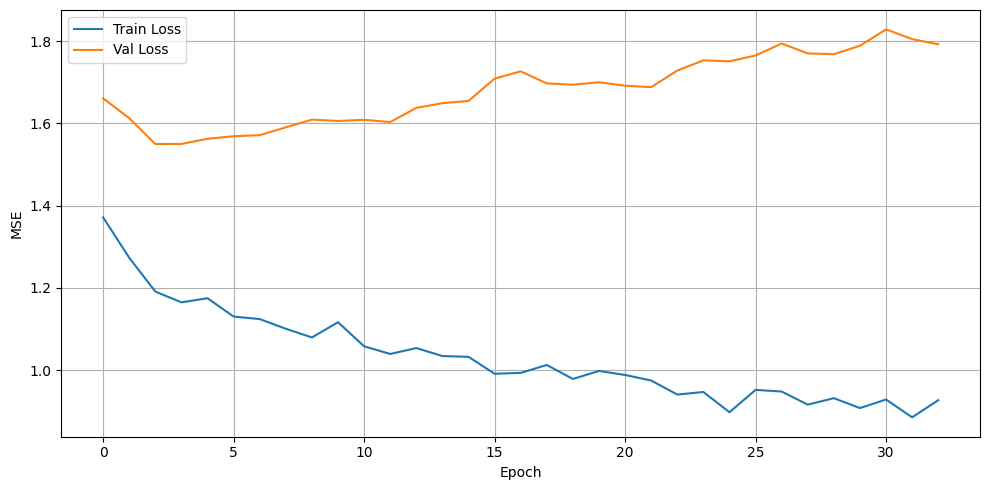

Train MSE: 0.9825, Test MSE: 2.0328
Train MAPE: 426984824444192.1875, Test MAPE: 621295196700672.6250
close_price test MSE: 0.1898316664822124
close_price test MAPE: 0.004825918102987743
close_price train MSE: 0.21869086267157842
close_price train MAPE: 0.004787898034637331


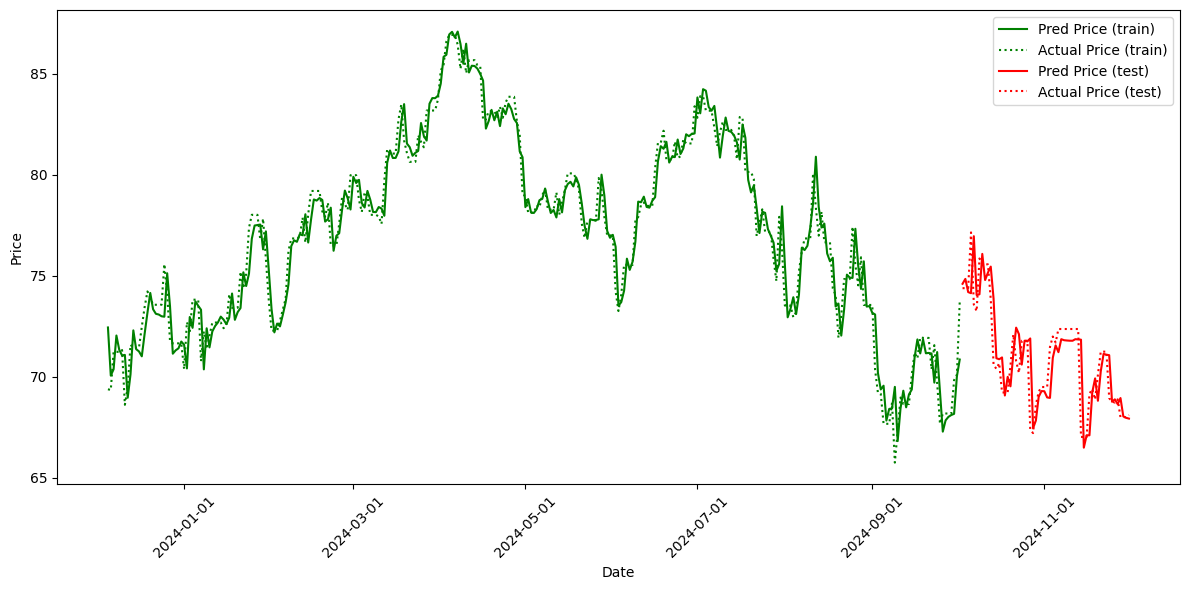

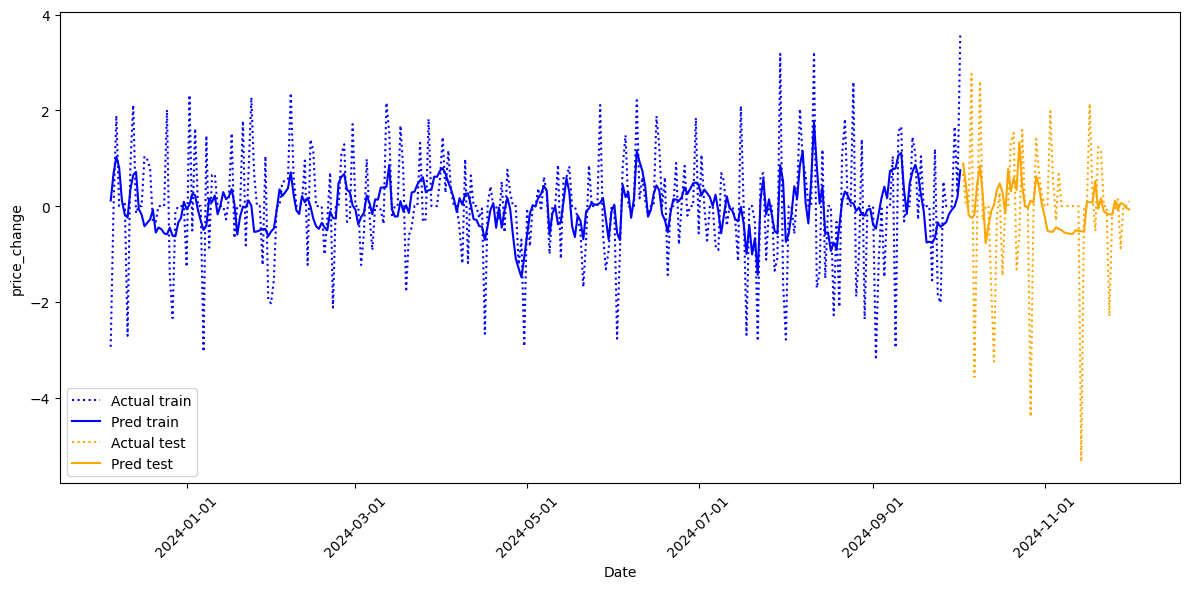

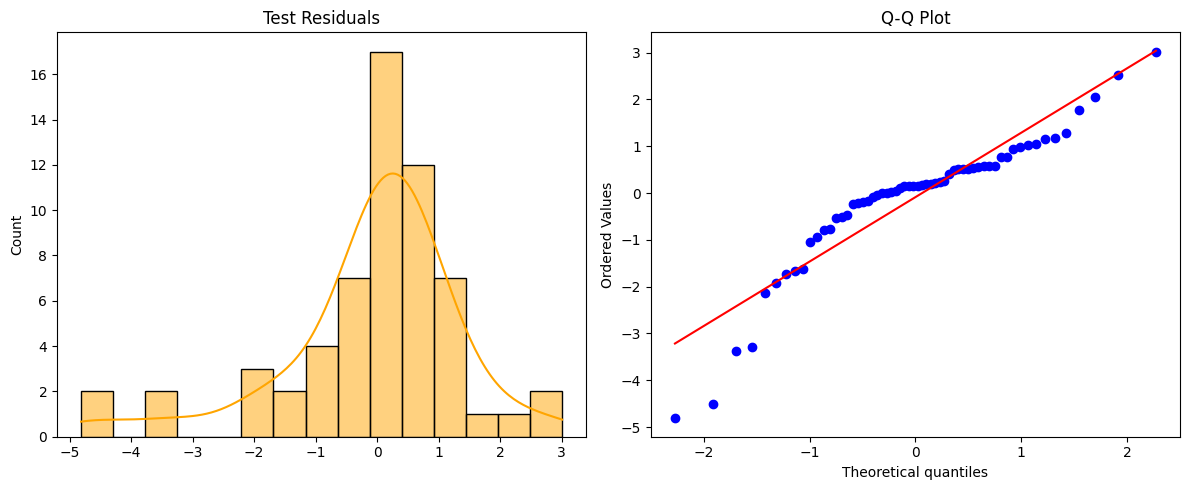

Shapiro-Wilk: stat=0.8867, p=0.0000


In [34]:
shift_days = 1

df = all_combinations.loc[all_combinations.ticker == 'CL=F'].ffill().copy()
df['next_day_close'] = df['close'].shift(-shift_days)
df['price_change'] = df['next_day_close'] - df['close']
df = df.dropna().reset_index(drop=True)


to_delete = ['business_date','close','price_change','next_day_close']
X_tmp = df.drop(to_delete, axis=1, errors='ignore')\
          .select_dtypes(['int','float'])

input_dim = X_tmp.shape[1]
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.1
)

model, scaler, feature_names = run_transformer_model(
    target='price_change',
    ticker_name='CL=F',
    model=model,
    test_len=60,
    to_delete=to_delete,
    shift_days=shift_days,
    all_combinations=all_combinations,
    sequence_length=20,
    epochs=2000,
    batch_size=32,
    lr=1e-4,
    patience=30
)

Epoch 1/2000  Train: 3.4483  Val: 3.1675
Epoch 2/2000  Train: 3.2082  Val: 3.0880
Epoch 3/2000  Train: 3.2084  Val: 3.0798
Epoch 4/2000  Train: 3.1719  Val: 3.1074
Epoch 63/2000  Train: 1.2314  Val: 2.7414
Epoch 64/2000  Train: 1.2363  Val: 2.7600
Epoch 65/2000  Train: 1.2097  Val: 2.7451
Epoch 66/2000  Train: 1.2447  Val: 2.6537
Early stopping at epoch 66


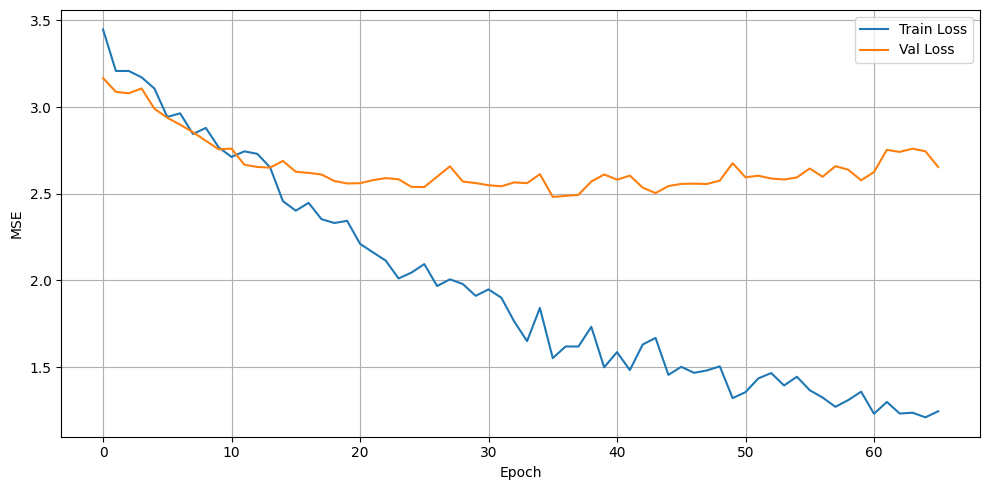

Train MSE: 1.2247, Test MSE: 5.1432
Train MAPE: 69517130686928.1562, Test MAPE: 480331224317953.1250
close_price test MSE: 1.4215483481247604
close_price test MAPE: 0.013781404896511114
close_price train MSE: 2.6129266061536374
close_price train MAPE: 0.01701087631535093


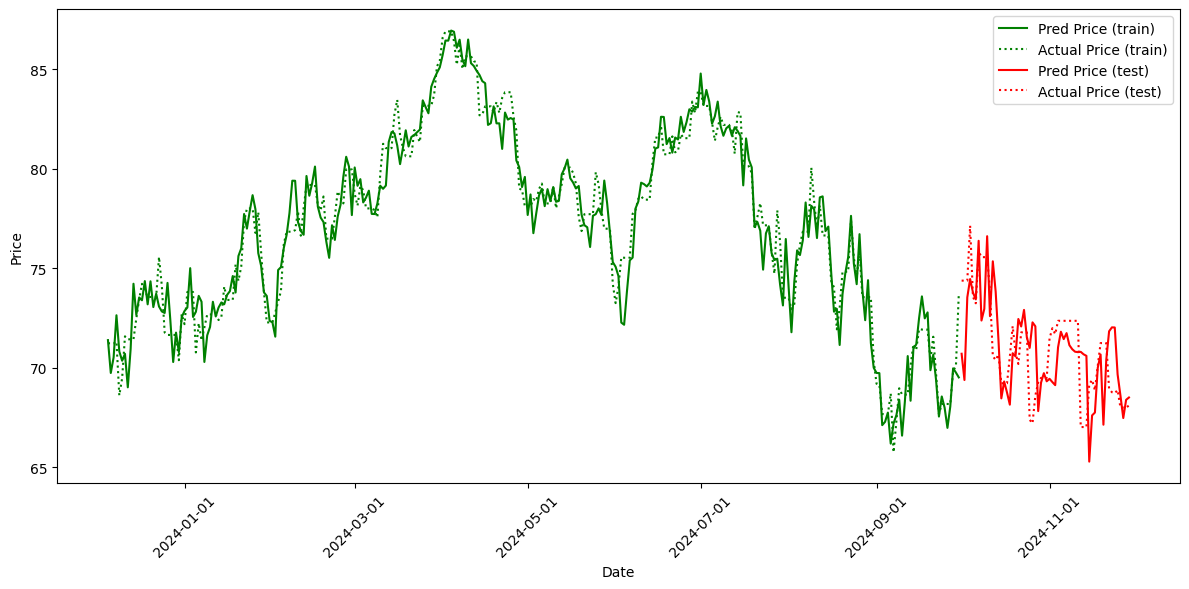

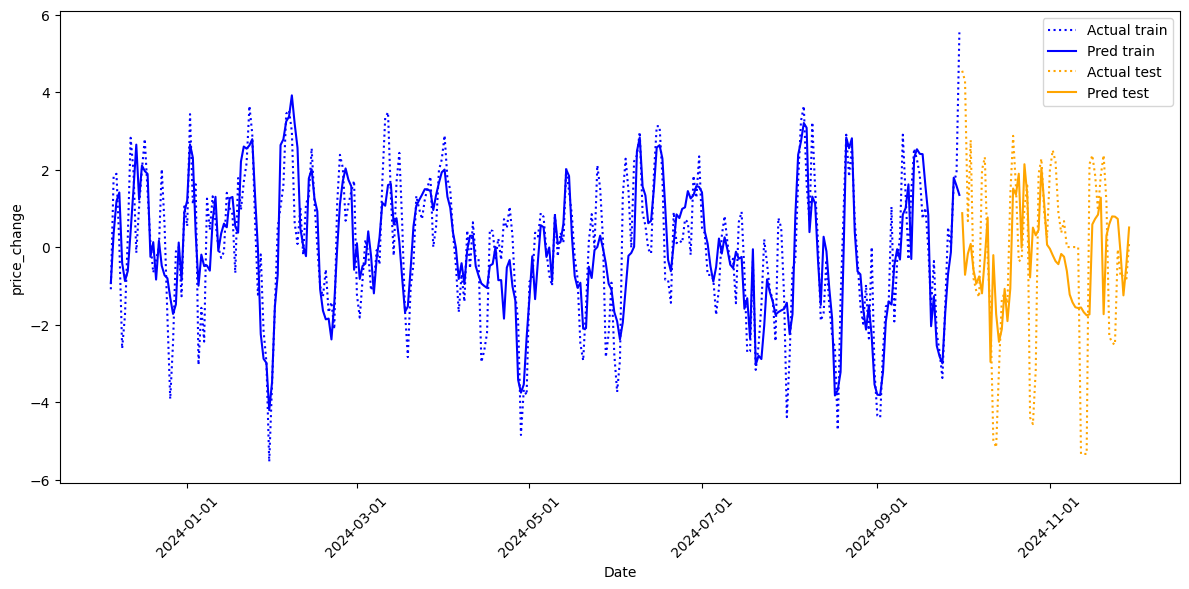

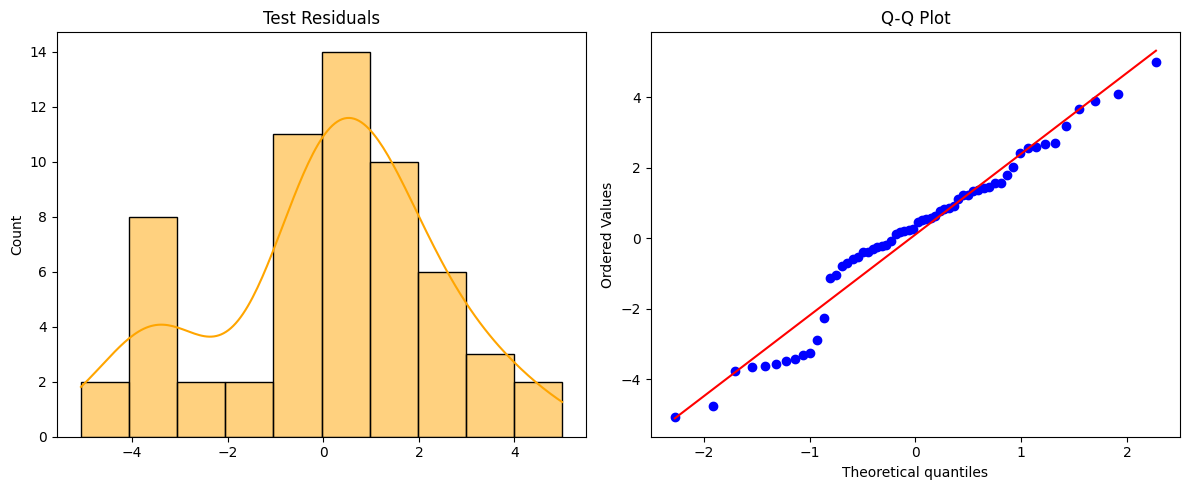

Shapiro-Wilk: stat=0.9604, p=0.0490


In [33]:
shift_days = 3

df = all_combinations.loc[all_combinations.ticker == 'CL=F'].ffill().copy()
df['next_day_close'] = df['close'].shift(-shift_days)
df['price_change'] = df['next_day_close'] - df['close']
df = df.dropna().reset_index(drop=True)


to_delete = ['business_date','close','price_change','next_day_close']
X_tmp = df.drop(to_delete, axis=1, errors='ignore')\
          .select_dtypes(['int','float'])

input_dim = X_tmp.shape[1]
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.1
)

model, scaler, feature_names = run_transformer_model(
    target='price_change',
    ticker_name='CL=F',
    model=model,
    test_len=60,
    to_delete=to_delete,
    shift_days=shift_days,
    all_combinations=all_combinations,
    sequence_length=20,
    epochs=2000,
    batch_size=32,
    lr=1e-4,
    patience=30
)

Epoch 1/2000  Train: 5.9591  Val: 5.1198
Epoch 2/2000  Train: 5.6547  Val: 5.0215
Epoch 3/2000  Train: 5.6055  Val: 4.7796
Epoch 4/2000  Train: 5.4622  Val: 4.7060
Epoch 123/2000  Train: 1.1159  Val: 2.2383
Epoch 124/2000  Train: 0.9180  Val: 2.1331
Early stopping at epoch 124


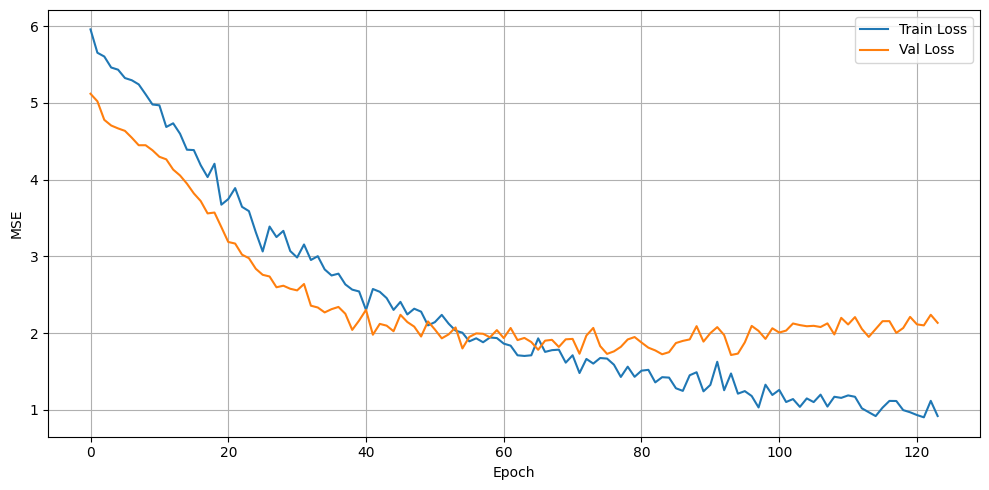

Train MSE: 0.8719, Test MSE: 8.4540
Train MAPE: 1.3381, Test MAPE: 477915953932972.5625
close_price test MSE: 5.0282320639282965
close_price test MAPE: 0.027198655133483317
close_price train MSE: 5.935644525463337
close_price train MAPE: 0.026341909017319334


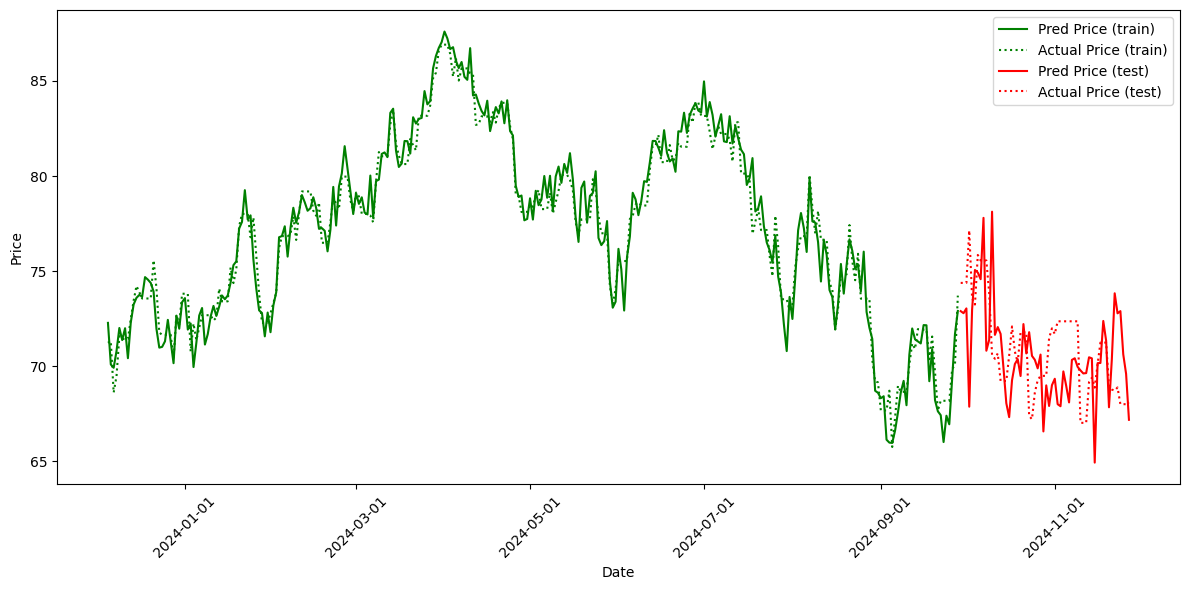

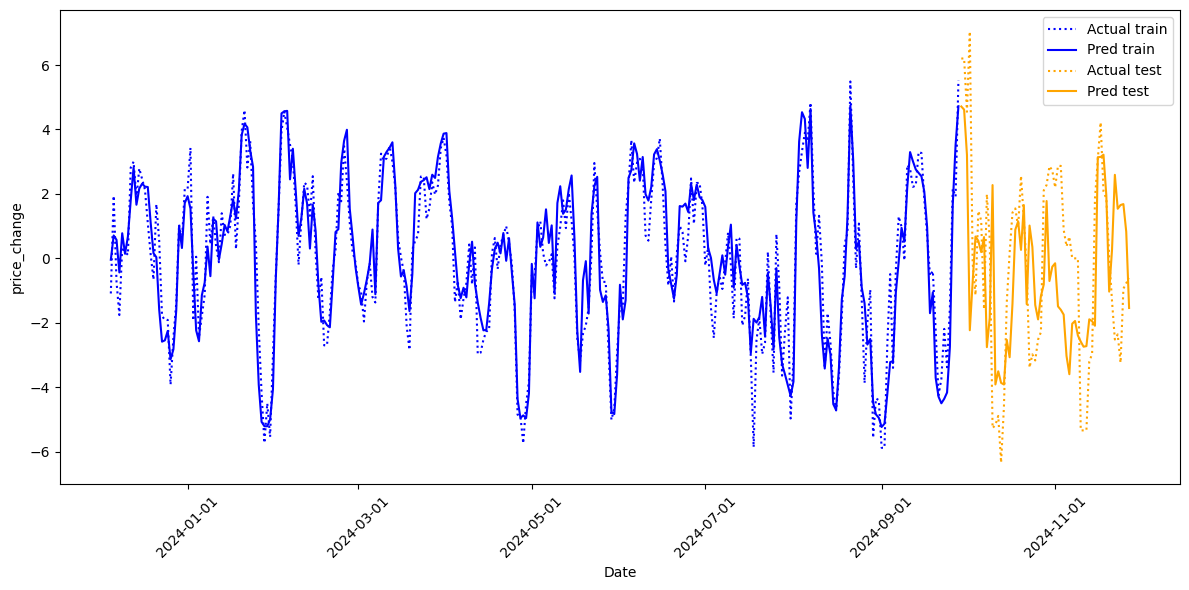

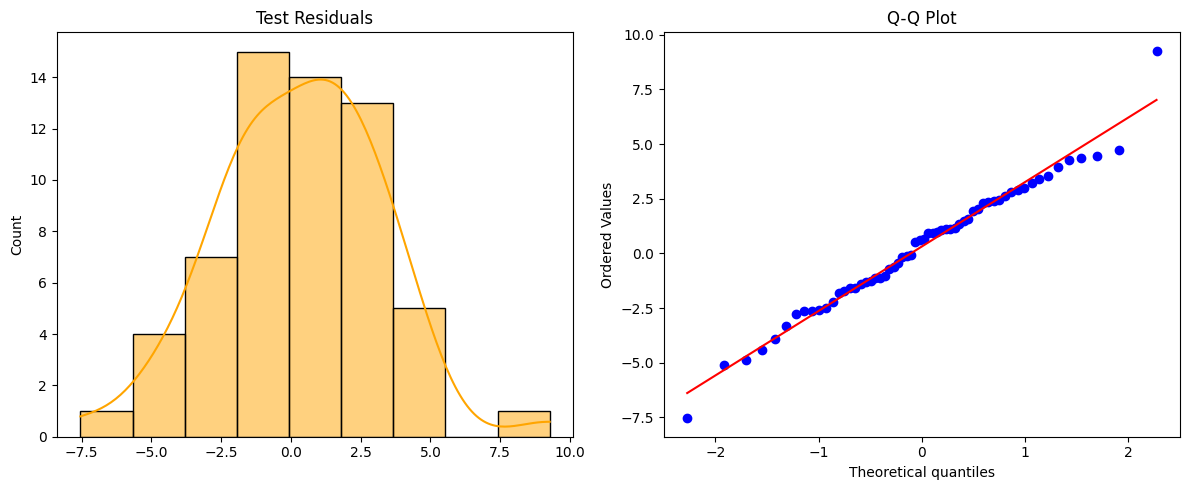

Shapiro-Wilk: stat=0.9854, p=0.6912


In [28]:
shift_days = 5

df = all_combinations.loc[all_combinations.ticker == 'CL=F'].ffill().copy()
df['next_day_close'] = df['close'].shift(-shift_days)
df['price_change'] = df['next_day_close'] - df['close']
df = df.dropna().reset_index(drop=True)


to_delete = ['business_date','close','price_change','next_day_close']
X_tmp = df.drop(to_delete, axis=1, errors='ignore')\
          .select_dtypes(['int','float'])

input_dim = X_tmp.shape[1]
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.1
)

model, scaler, feature_names = run_transformer_model(
    target='price_change',
    ticker_name='CL=F',
    model=model,
    test_len=60,
    to_delete=to_delete,
    shift_days=shift_days,
    all_combinations=all_combinations,
    sequence_length=20,
    epochs=2000,
    batch_size=32,
    lr=1e-4,
    patience=30
)

Epoch 1/2000  Train: 10.1662  Val: 9.0123
Epoch 74/2000  Train: 1.7754  Val: 3.0508
Epoch 75/2000  Train: 2.0563  Val: 3.0159
Early stopping at epoch 75


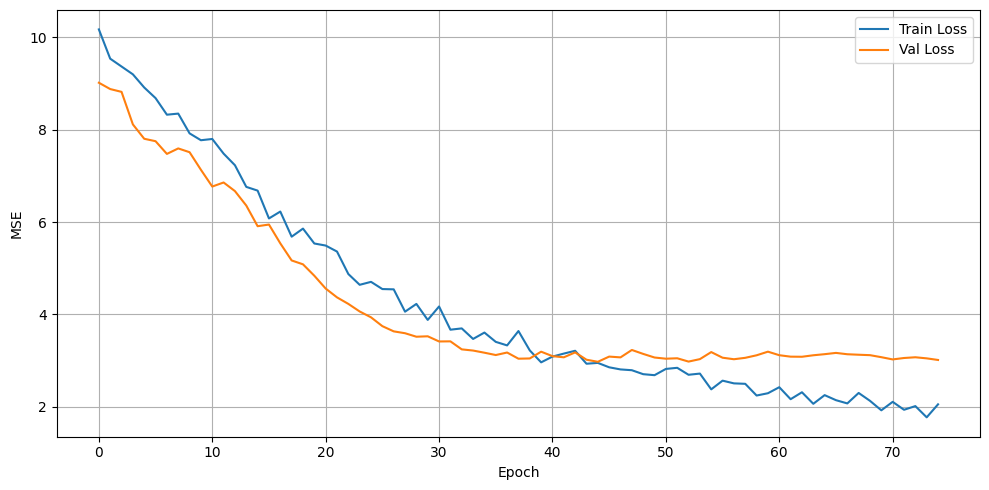

Train MSE: 1.7359, Test MSE: 16.1451
Train MAPE: 1.8146, Test MAPE: 1.9706
close_price test MSE: 6.841556469718944
close_price test MAPE: 0.030674415874159797
close_price train MSE: 9.091175330844672
close_price train MAPE: 0.03360185293318082


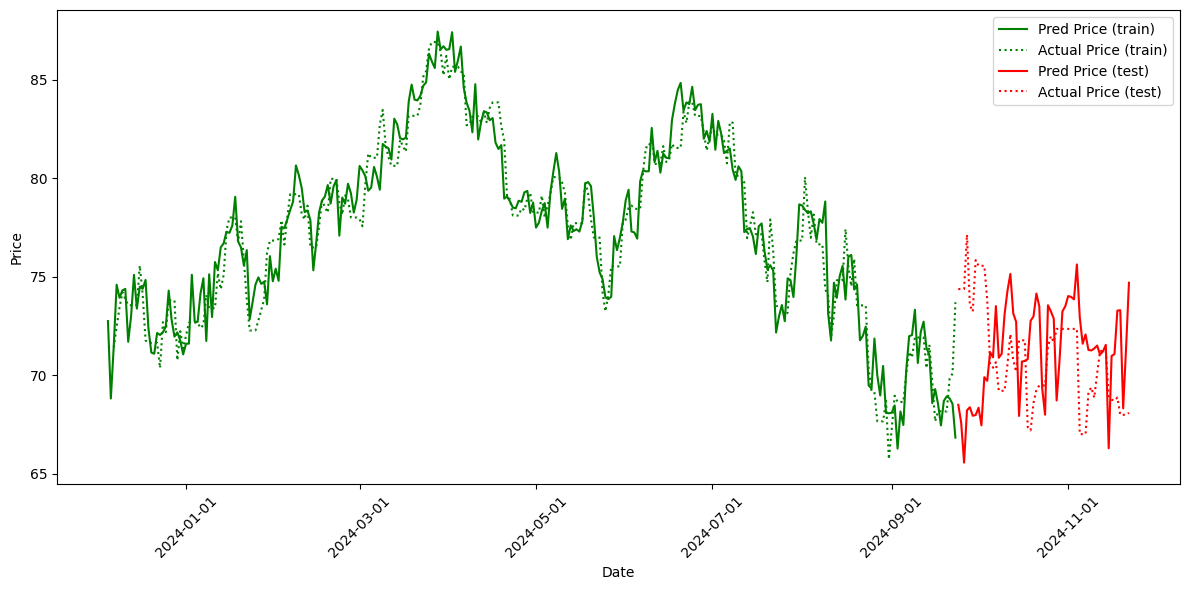

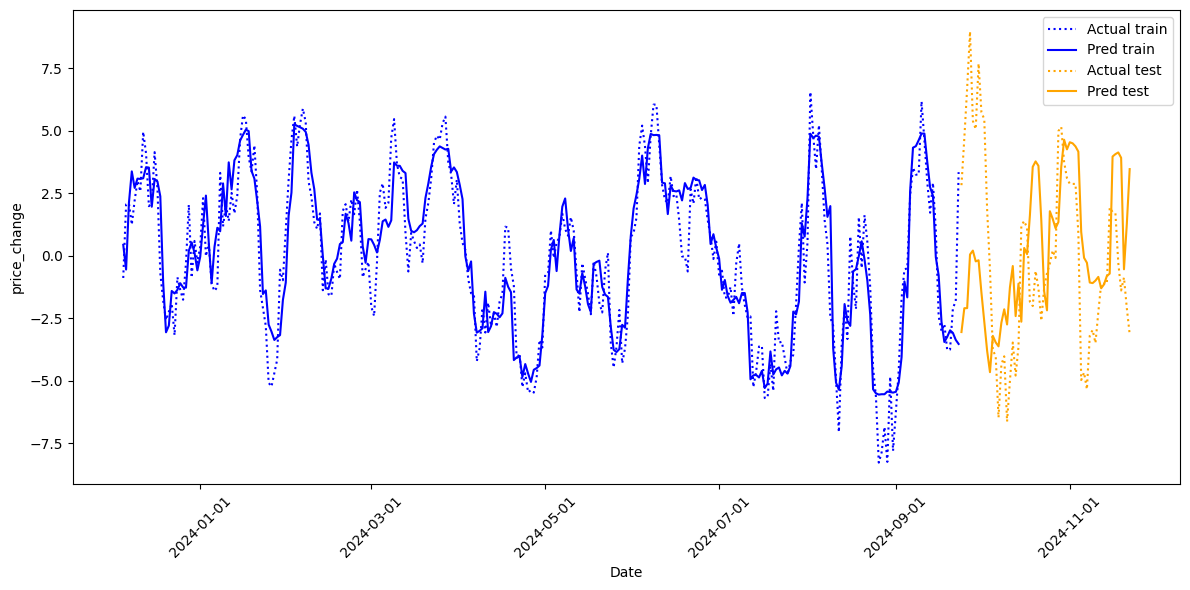

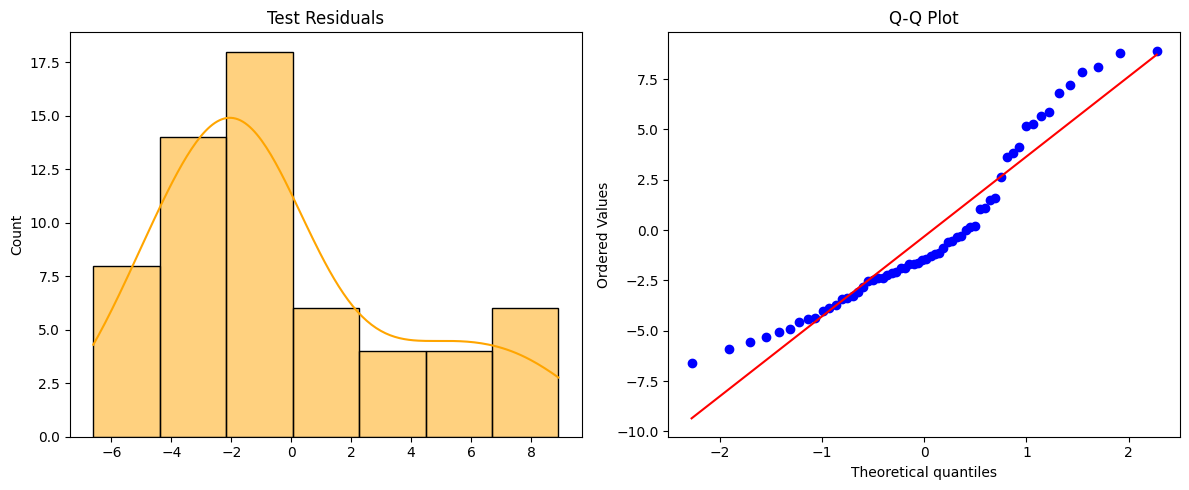

Shapiro-Wilk: stat=0.9175, p=0.0006


In [27]:
shift_days = 10

df = all_combinations.loc[all_combinations.ticker == 'CL=F'].ffill().copy()
df['next_day_close'] = df['close'].shift(-shift_days)
df['price_change'] = df['next_day_close'] - df['close']
df = df.dropna().reset_index(drop=True)


to_delete = ['business_date','close','price_change','next_day_close']
X_tmp = df.drop(to_delete, axis=1, errors='ignore')\
          .select_dtypes(['int','float'])

input_dim = X_tmp.shape[1]
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.1
)

model, scaler, feature_names = run_transformer_model(
    target='price_change',
    ticker_name='CL=F',
    model=model,
    test_len=60,
    to_delete=to_delete,
    shift_days=shift_days,
    all_combinations=all_combinations,
    sequence_length=20,
    epochs=2000,
    batch_size=32,
    lr=1e-4,
    patience=30
)

Epoch 1/2000  Train: 11.9748  Val: 12.0621
Epoch 2/2000  Train: 11.1523  Val: 11.5572
Epoch 3/2000  Train: 10.8215  Val: 10.9067
Epoch 4/2000  Train: 10.1440  Val: 10.5630
Epoch 5/2000  Train: 9.8594  Val: 10.0700
Epoch 6/2000  Train: 9.3769  Val: 9.6232
Epoch 7/2000  Train: 9.0459  Val: 9.2510
Epoch 8/2000  Train: 8.5881  Val: 8.9856
Epoch 9/2000  Train: 8.3035  Val: 8.6226
Epoch 10/2000  Train: 8.0036  Val: 8.0216
Epoch 11/2000  Train: 8.0361  Val: 7.5090
Epoch 12/2000  Train: 7.2555  Val: 7.4069
Epoch 13/2000  Train: 7.0449  Val: 6.9350
Epoch 14/2000  Train: 6.6332  Val: 6.3395
Epoch 15/2000  Train: 6.2090  Val: 5.9373
Epoch 16/2000  Train: 6.1115  Val: 5.6163
Epoch 17/2000  Train: 5.6917  Val: 5.3417
Epoch 18/2000  Train: 5.5828  Val: 5.0030
Epoch 19/2000  Train: 5.2207  Val: 4.8159
Epoch 20/2000  Train: 4.8702  Val: 4.4531
Epoch 21/2000  Train: 5.2233  Val: 4.4173
Epoch 22/2000  Train: 4.6636  Val: 4.4432
Epoch 23/2000  Train: 4.6949  Val: 4.6037
Epoch 24/2000  Train: 4.6019  Val:

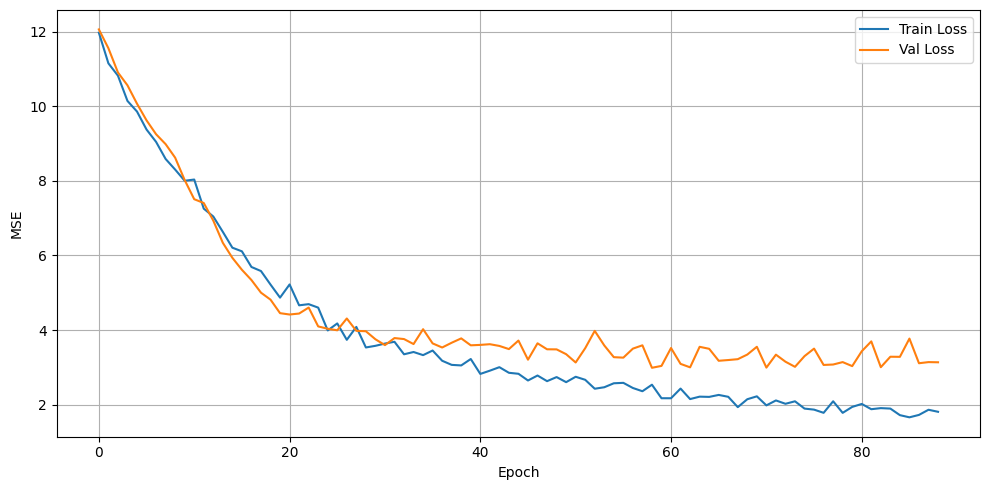

Train MSE: 1.6714, Test MSE: 10.5400
Train MAPE: 1.4857, Test MAPE: 1.4549
close_price test MSE: 2.7468352665653026
close_price test MAPE: 0.019072350083994195
close_price train MSE: 11.851369526002104
close_price train MAPE: 0.03774978715644626


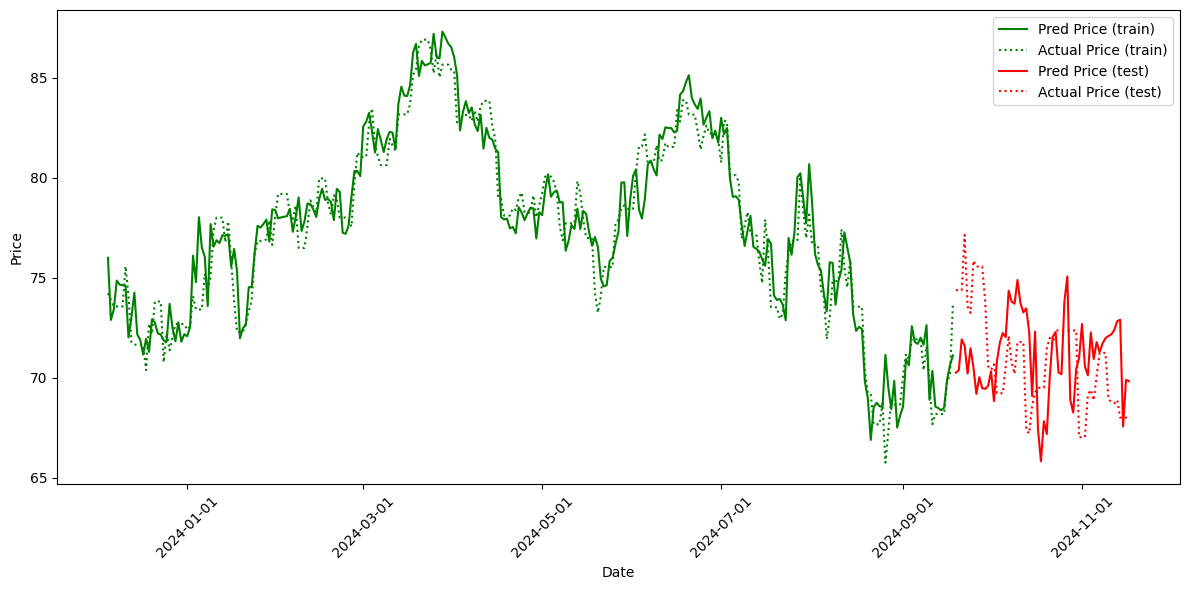

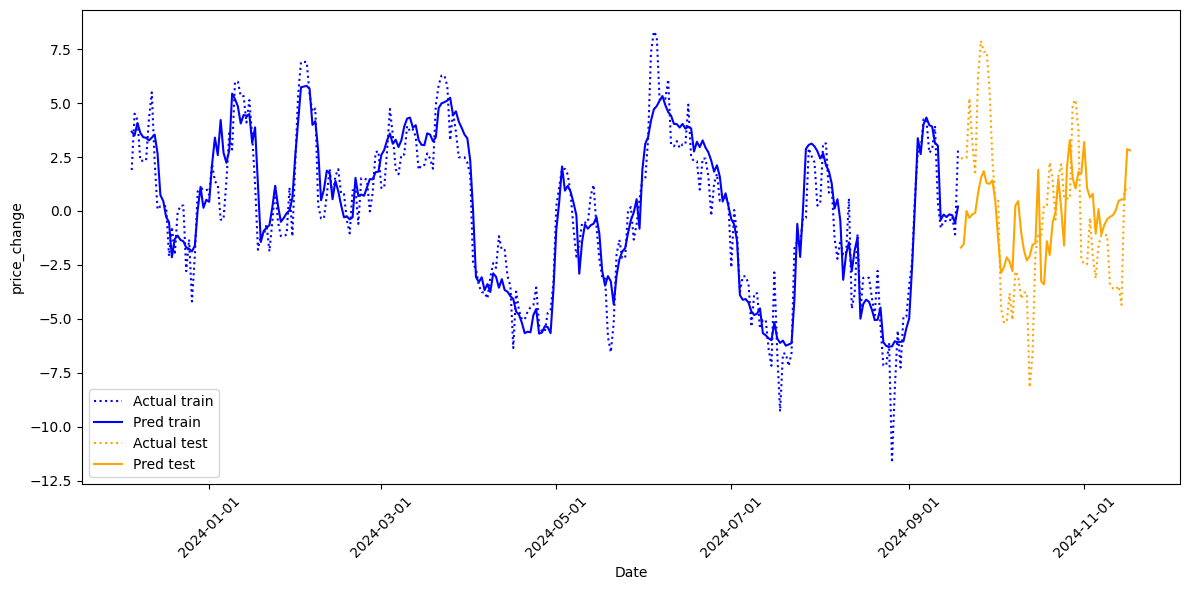

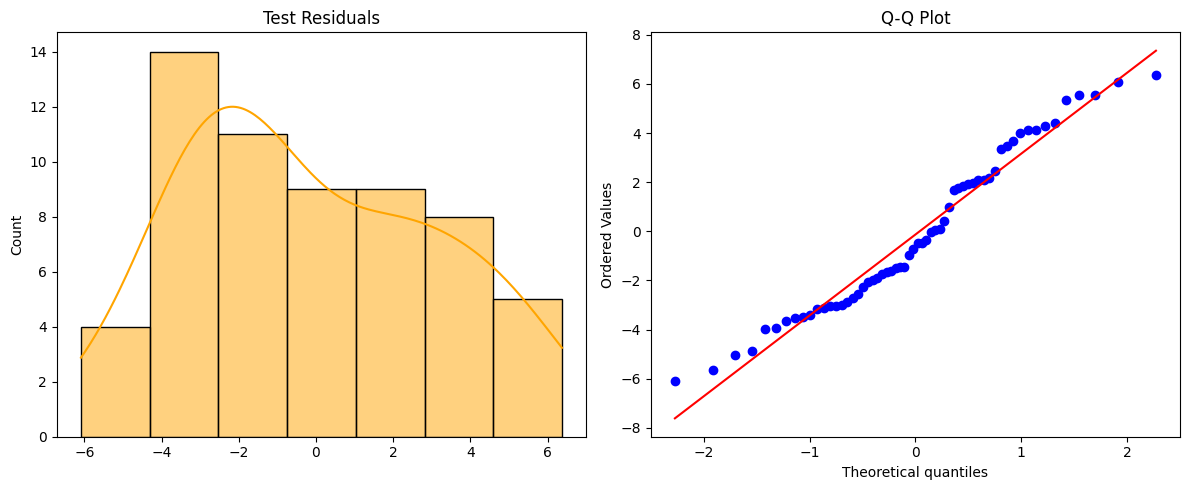

Shapiro-Wilk: stat=0.9596, p=0.0448


In [ ]:
shift_days = 15

df = all_combinations.loc[all_combinations.ticker == 'CL=F'].ffill().copy()
df['next_day_close'] = df['close'].shift(-shift_days)
df['price_change'] = df['next_day_close'] - df['close']
df = df.dropna().reset_index(drop=True)


to_delete = ['business_date','close','price_change','next_day_close']
X_tmp = df.drop(to_delete, axis=1, errors='ignore')\
          .select_dtypes(['int','float'])

input_dim = X_tmp.shape[1]
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.1
)

model, scaler, feature_names = run_transformer_model(
    target='price_change',
    ticker_name='CL=F',
    model=model,
    test_len=60,
    to_delete=to_delete,
    shift_days=shift_days,
    all_combinations=all_combinations,
    sequence_length=20,
    epochs=2000,
    batch_size=32,
    lr=1e-4,
    patience=30
)

Epoch 1/2000  Train: 14.4229  Val: 16.6747
Epoch 2/2000  Train: 13.2942  Val: 15.6987
Epoch 3/2000  Train: 12.5577  Val: 14.7248
Epoch 165/2000  Train: 1.2218  Val: 3.6147
Epoch 166/2000  Train: 1.1738  Val: 3.7099
Epoch 167/2000  Train: 1.1701  Val: 3.5829
Epoch 168/2000  Train: 1.1307  Val: 3.4003
Epoch 169/2000  Train: 1.0100  Val: 3.5743
Early stopping at epoch 169


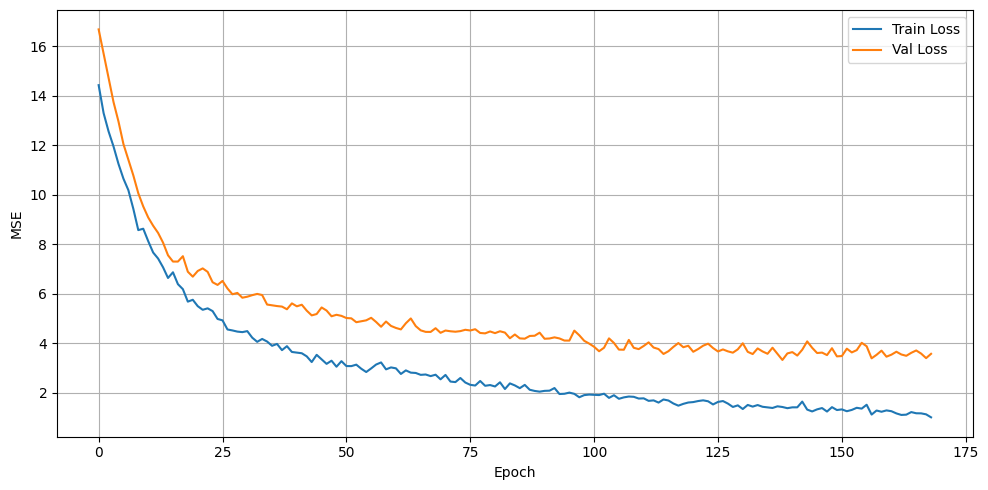

Train MSE: 1.2694, Test MSE: 16.1254
Train MAPE: 14842492971153.1406, Test MAPE: 1.5017
close_price test MSE: 2.902273503834193
close_price test MAPE: 0.020512650673719365
close_price train MSE: 14.967746167131102
close_price train MAPE: 0.04201902672673963


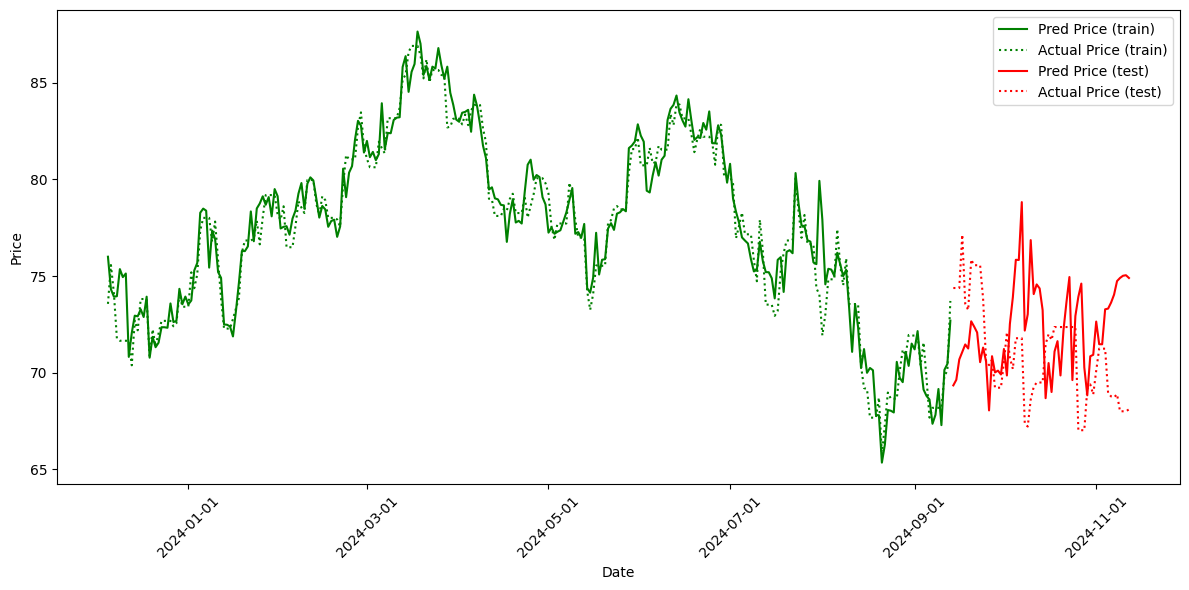

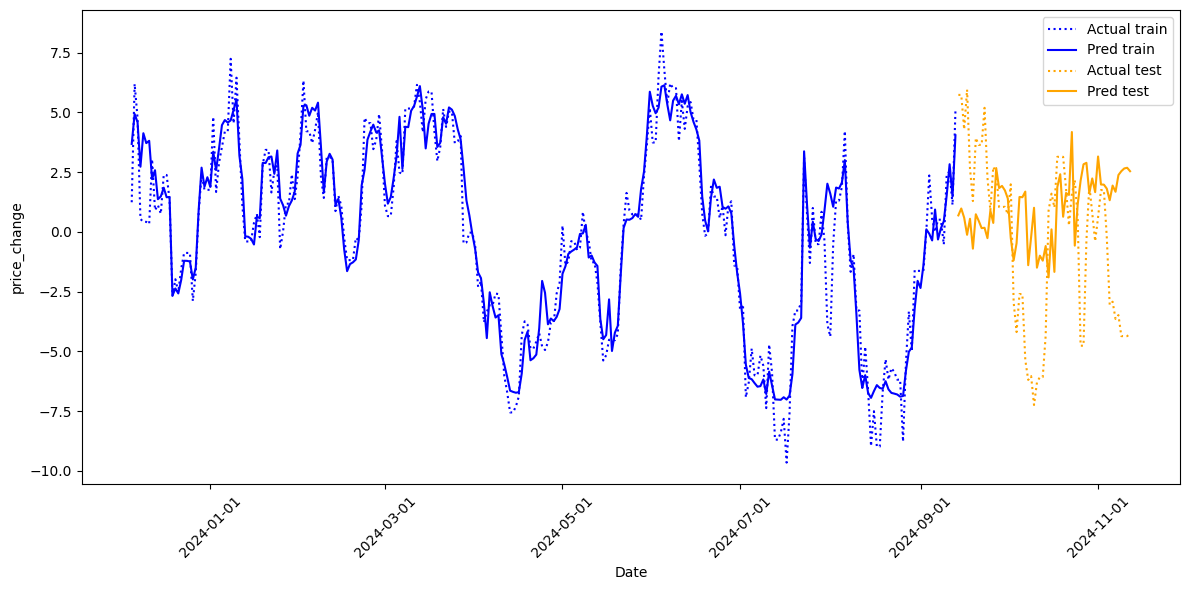

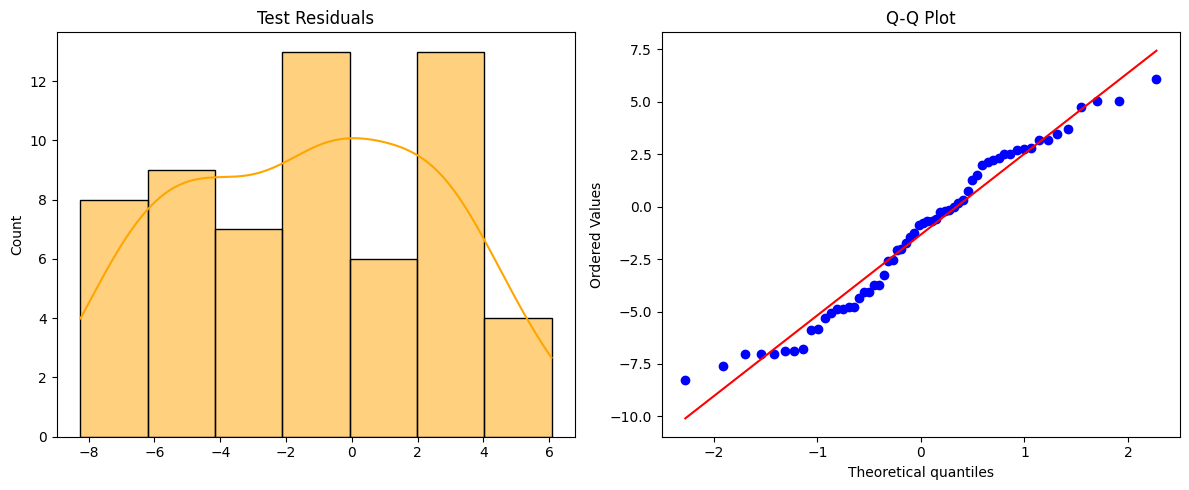

Shapiro-Wilk: stat=0.9628, p=0.0648


In [30]:

shift_days = 20

df = all_combinations.loc[all_combinations.ticker == 'CL=F'].ffill().copy()
df['next_day_close'] = df['close'].shift(-shift_days)
df['price_change'] = df['next_day_close'] - df['close']
df = df.dropna().reset_index(drop=True)


to_delete = ['business_date','close','price_change','next_day_close']
X_tmp = df.drop(to_delete, axis=1, errors='ignore')\
          .select_dtypes(['int','float'])

input_dim = X_tmp.shape[1]
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.1
)

model, scaler, feature_names = run_transformer_model(
    target='price_change',
    ticker_name='CL=F',
    model=model,
    test_len=60,
    to_delete=to_delete,
    shift_days=shift_days,
    all_combinations=all_combinations,
    sequence_length=20,
    epochs=2000,
    batch_size=32,
    lr=1e-4,
    patience=30
)